In [1]:
# 3rd party
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import lightkurve as lk

import tensorflow as tf

In [2]:
study_dir = Path(f"/Users/jochoa4/Desktop/studies/study_model_preds_05-22-2025/")
study_dir.mkdir(parents=True, exist_ok=True)


plot_dir = study_dir / "plots"
plot_dir.mkdir(parents=True, exist_ok=True)


## Replication of Miguel's Study on model predictions

In [ ]:
scores_tbls_dir = Path(
    "/Users/jochoa4/Desktop/pfe_transfers/predict_model_05-04-2025_v2_e19/"
)

scores_tbl_fp = scores_tbls_dir / "preds_train.csv"

tce_tbl_fp = Path(
    "/Users/jochoa4/Projects/exoplanet_transit_classification/ephemeris_tables/preprocessing_tce_tables/tess_2min_tces_dv_s1-s68_all_msectors_11-29-2023_2157_newlabels_nebs_npcs_bds_ebsntps_to_unks.csv"
)

tce_tbl = pd.read_csv(tce_tbl_fp)
tce_tbl = tce_tbl.rename(columns={"uid": "tce_uid", "label": "disposition"})

train_tbl = pd.read_csv(scores_tbls_dir / "preds_train.csv")

def _get_tce_uid_from_examples(x):
    tce_uid = x["uid"].split("_")[0]
    return tce_uid

def _get_target_id_from_examples(x):
    target_id = x["uid"].split("-")[0]
    return target_id

train_tbl["tce_uid"] = train_tbl.apply(_get_tce_uid_from_examples, axis=1)
train_tbl["target_id"] = train_tbl.apply(_get_target_id_from_examples, axis=1)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_max_mult_ev"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_time0bk"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_period"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)


train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_max_mult_ev"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_maxmes"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_maxmesd"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "tce_time0bk"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

train_tbl = train_tbl.merge(
    tce_tbl[["tce_uid", "sector_run"]],
    on="tce_uid",
    how="left",
    validate="many_to_one",
)

/var/folders/_z/srkh35f94rd_6jrkc3kv29hm0000gp/T/ipykernel_27006/2933692010.py:11: DtypeWarning: Columns (364,366,367,370,371) have mixed types. Specify dtype option on import or set low_memory=False.
  tce_tbl = pd.read_csv(tce_tbl_fp)


### Show non-transit/transit model score vs example count by disposition

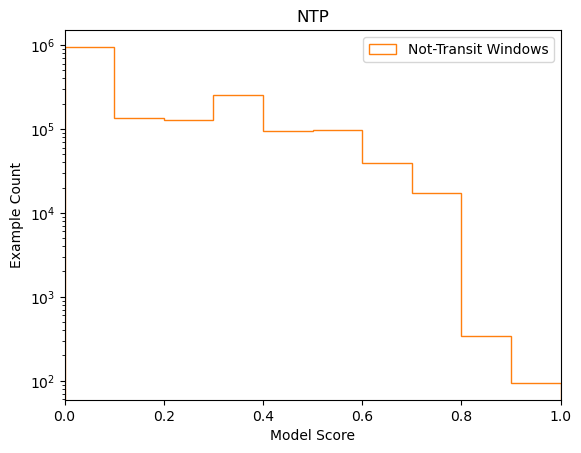

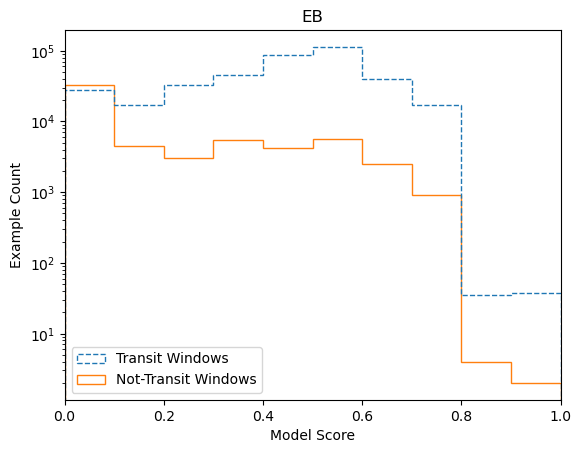

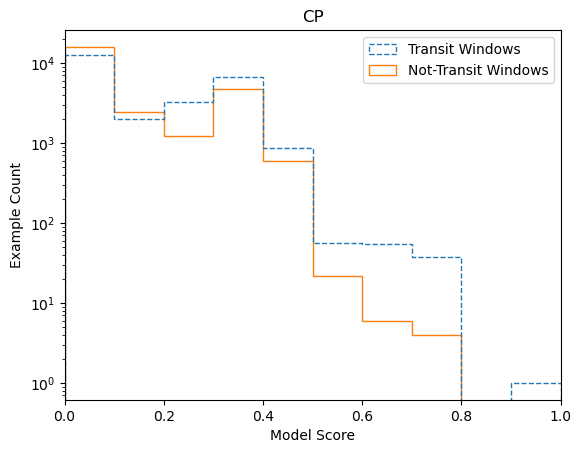

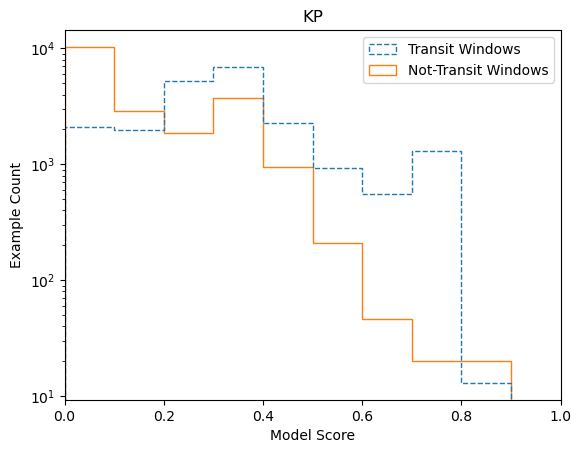

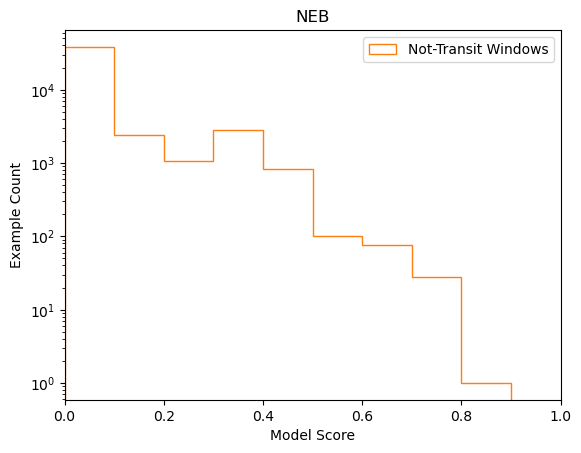

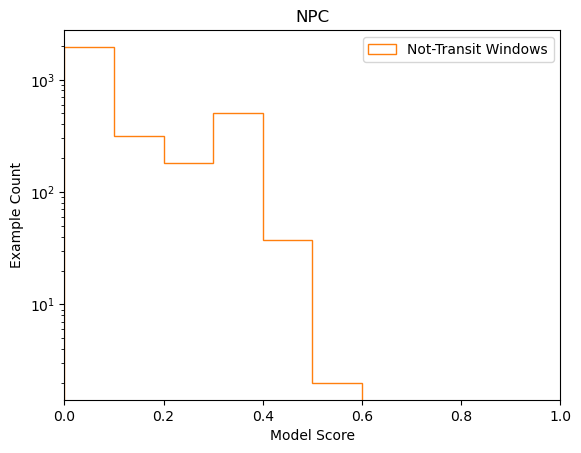

In [4]:
bins_scores = np.linspace(0, 1, 11)

for disp in train_tbl["disposition"].unique():

    train_tbl_disp = train_tbl.loc[train_tbl["disposition"] == disp]

    transit_window_examples = train_tbl_disp.loc[train_tbl_disp["label"] == 1]
    not_transit_window_examples = train_tbl_disp.loc[train_tbl_disp["label"] == 0]

    f, ax = plt.subplots()

    if len(transit_window_examples) > 0:
        ax.hist(
            transit_window_examples["raw_pred"],
            bins_scores,
            histtype="step",
            label="Transit Windows",
            zorder=2,
            linestyle="dashed",
            color="#1f77b4",
        )
    if len(not_transit_window_examples) > 0:
        ax.hist(
            not_transit_window_examples["raw_pred"],
            bins_scores,
            histtype="step",
            label="Not-Transit Windows",
            zorder=1,
            color="#ff7f0e",
        )

    ax.set_ylabel("Example Count")
    ax.set_xlabel("Model Score")
    ax.set_yscale("log")
    ax.set_title(f"{disp}")
    ax.legend()
    ax.set_xlim(bins_scores[[0, -1]])
    f.savefig(plot_dir / f"hist_model_scores_{disp}.png")
    plt.show()

### Show TCE_MES vs Model Score by Disposition/Label

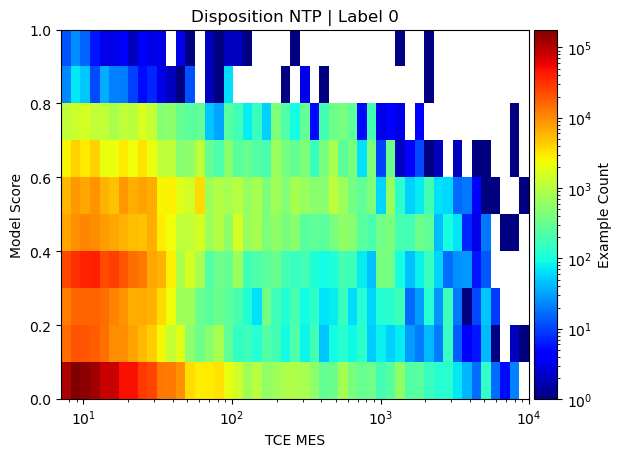

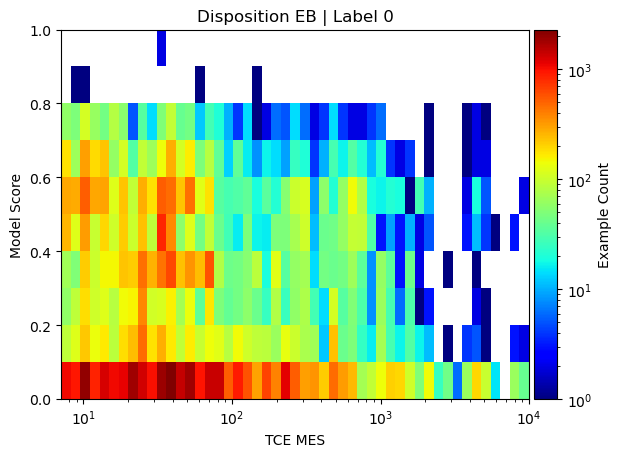

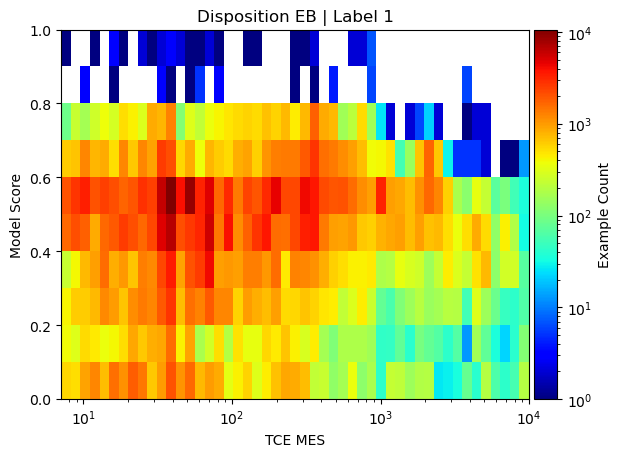

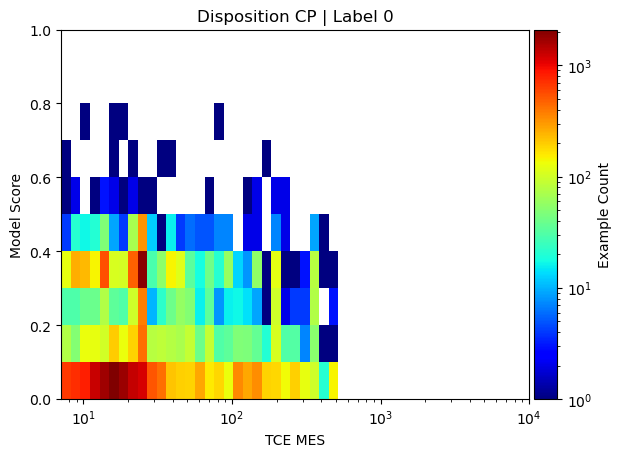

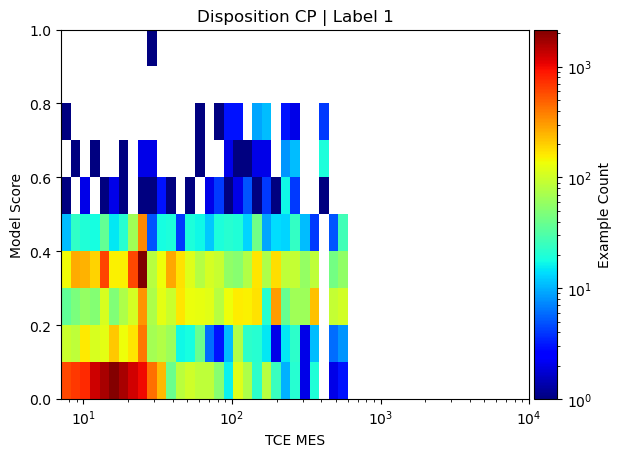

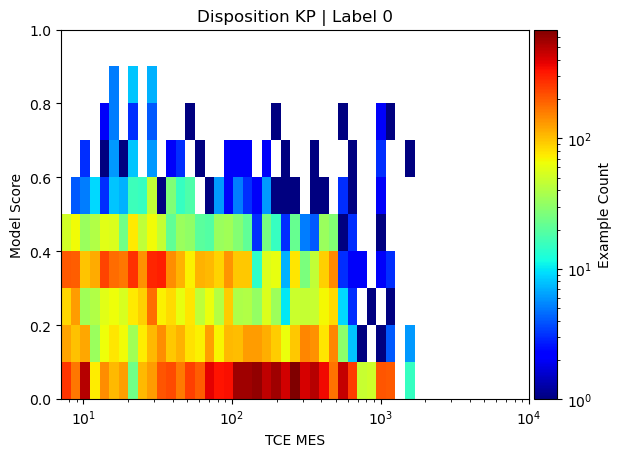

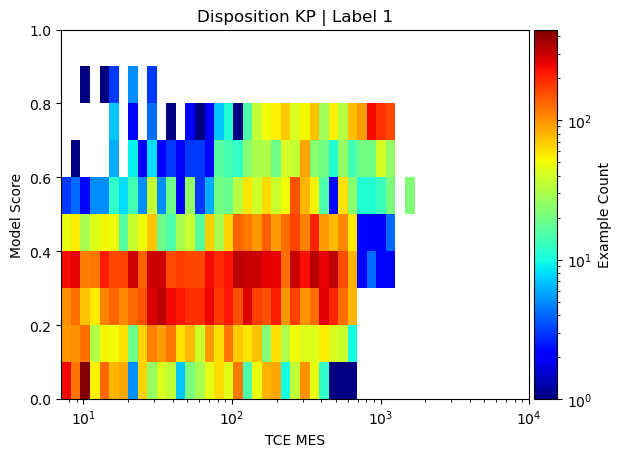

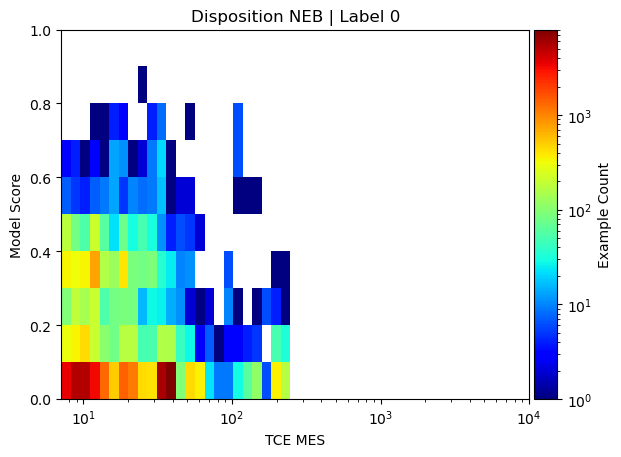

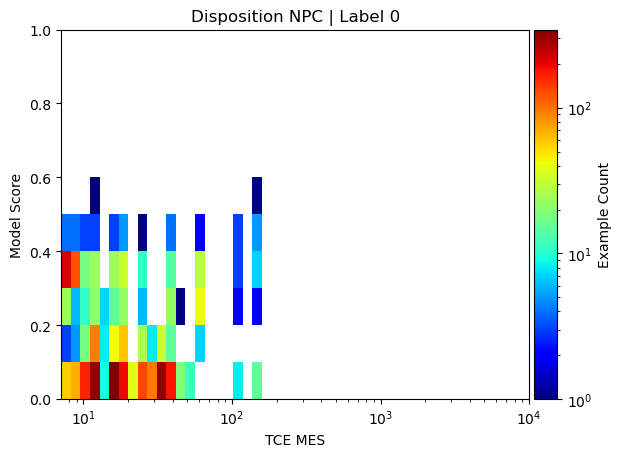

In [5]:
bins_mes = np.logspace(np.log10(7.1), 4, 50)
bins_scores = np.linspace(0, 1, 11)

for disp in train_tbl["disposition"].unique():
    for label in train_tbl["label"].unique():

        train_tbl_disp = train_tbl.loc[
            ((train_tbl["disposition"] == disp) & (train_tbl["label"] == label))
        ]
        if len(train_tbl_disp) == 0:
            continue

        f, ax = plt.subplots()

        # ax.scatter(train_tbl_disp['tce_max_mult_ev'], train_tbl_disp['raw_pred'], s=8, alpha=0.01)
        # ax.set_ylim([0, 1])
        # ax.set_xlim(left=7.1)

        im = ax.hist2d(
            train_tbl_disp["tce_max_mult_ev"],
            train_tbl_disp["raw_pred"],
            bins=[bins_mes, bins_scores],
            cmap="jet",
            norm=LogNorm(),
        )[3]
        ax.set_ylim([0, 1])
        ax.set_xlim(left=7.1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax, label="Example Count")

        ax.set_xscale("log")

        ax.set_ylabel("Model Score")
        ax.set_xlabel("TCE MES")
        ax.set_title(f"Disposition {disp} | Label {label}")
        f.savefig(plot_dir / f"hist2d_model_scores_tcemes_{disp}.png")
        plt.show()


In [ ]:

avg_tce_score = (
    train_tbl[["tce_uid", "raw_pred", "label"]]
    .groupby(["tce_uid", "label"])
    .median()
    .reset_index()
)
avg_tce_score = avg_tce_score.merge(
    tce_tbl[["tce_uid", "disposition", "tce_max_mult_ev"]],
    how="left",
    on="tce_uid",
    validate="many_to_one",
)


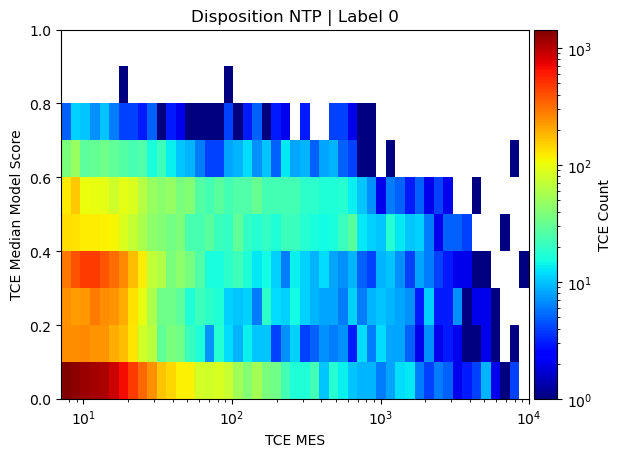

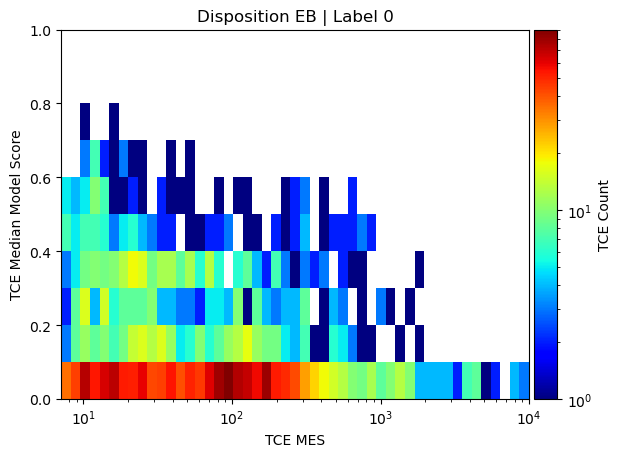

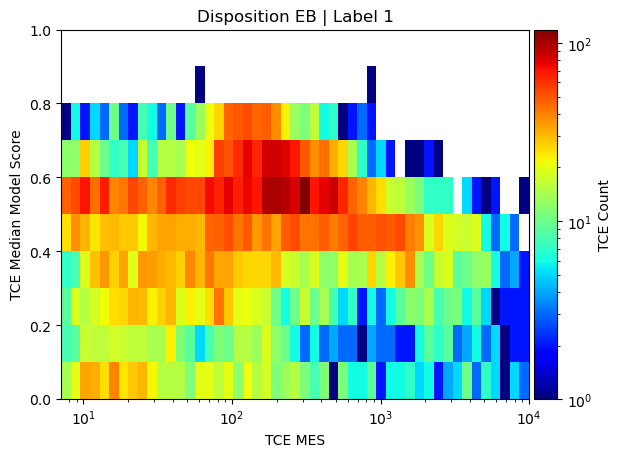

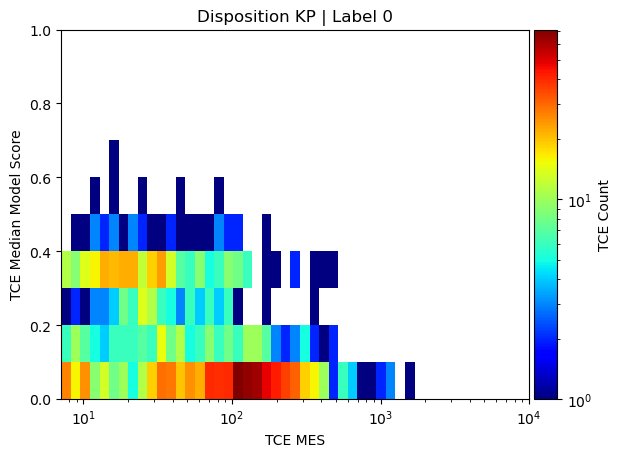

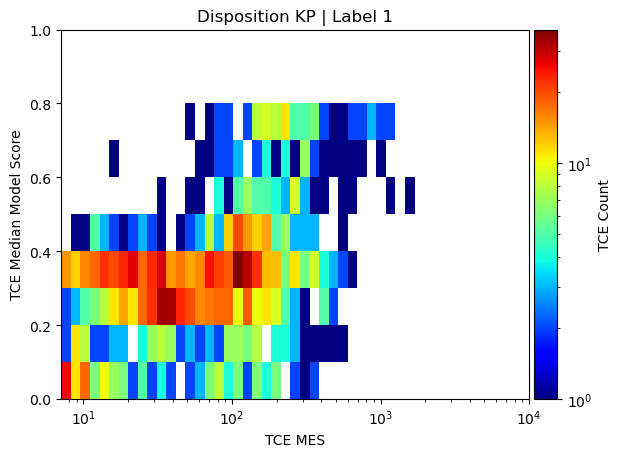

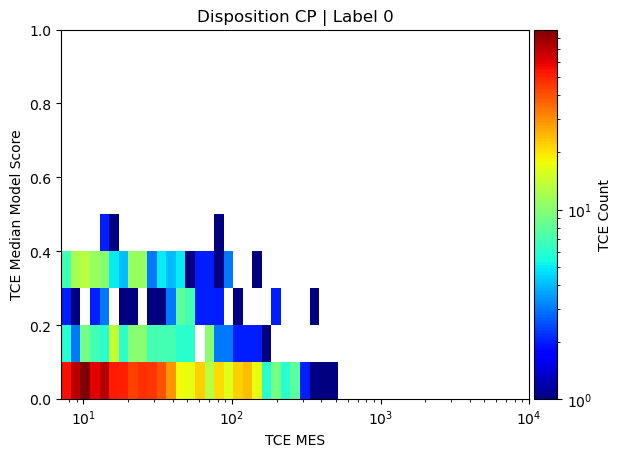

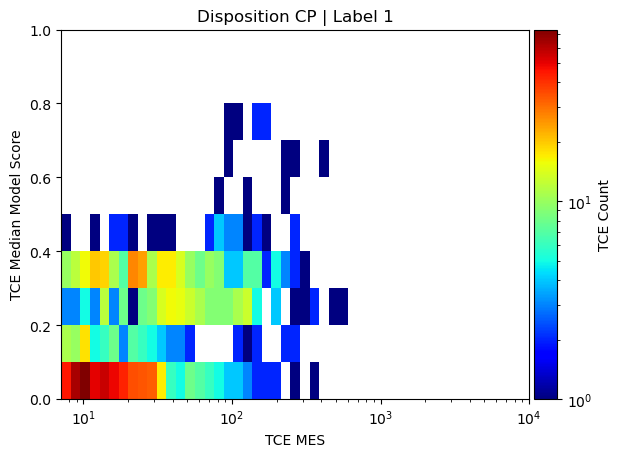

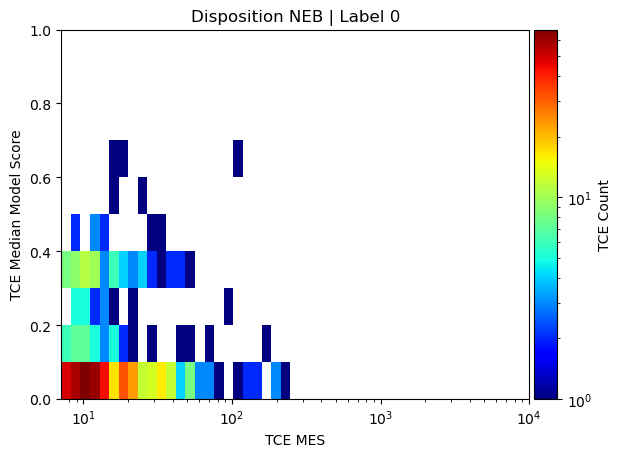

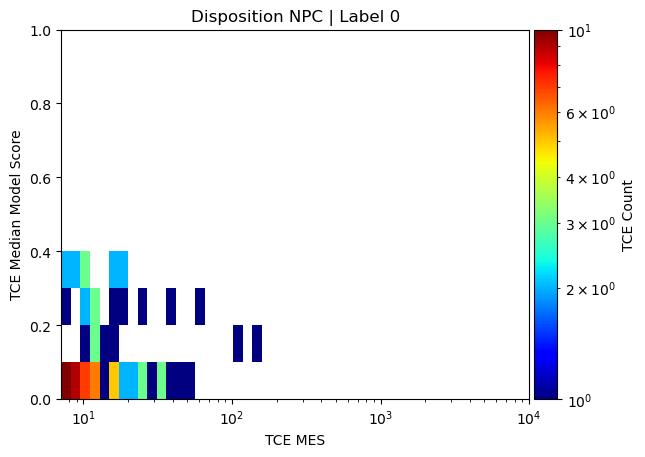

In [ ]:

bins_mes = np.logspace(np.log10(7.1), 4, 50)
bins_scores = np.linspace(0, 1, 11)

for disp in avg_tce_score["disposition"].unique():
    for label in avg_tce_score["label"].unique():

        avg_tce_score_disp = avg_tce_score.loc[
            ((avg_tce_score["disposition"] == disp) & (avg_tce_score["label"] == label))
        ]
        if len(avg_tce_score_disp) == 0:
            continue

        f, ax = plt.subplots()

        # ax.scatter(train_tbl_disp['tce_max_mult_ev'], train_tbl_disp['raw_pred'], s=8, alpha=0.01)
        # ax.set_ylim([0, 1])
        # ax.set_xlim(left=7.1)

        im = ax.hist2d(
            avg_tce_score_disp["tce_max_mult_ev"],
            avg_tce_score_disp["raw_pred"],
            bins=[bins_mes, bins_scores],
            cmap="jet",
            norm=LogNorm(),
        )[3]
        ax.set_ylim([0, 1])
        ax.set_xlim(left=7.1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax, label="TCE Count")

        ax.set_xscale("log")

        ax.set_ylabel("TCE Median Model Score")
        ax.set_xlabel("TCE MES")
        ax.set_title(f"Disposition {disp} | Label {label}")
        f.savefig(plot_dir / f"hist2d_model_scores_tcemes_mediantces_{disp}.png")
        plt.show()


# Finding interesting TCEs

In [8]:
# desc = train_tbl.groupby(["confusion", "cf_pred_band"]).describe()
# desc

In [9]:
def _compute_tce_stats(train_tbl):
    assert train_tbl.index.is_unique, "WARNING: 1-1 mapping not ensured for computation of tce_stats"
    df = train_tbl.copy()

    lc_neg_thresh, hc_neg_thresh = 0.4, 0.1
    lc_pos_thresh, hc_pos_thresh = 0.6, 0.9
    
    amb_thresh = 0.05
    

    df["is_low_conf_tp"] = (df["raw_pred" < lc_pos_thresh] & (df["confusion"] == "TP"))
    df["is_high_conf_tp"] = (df["raw_pred" > hc_pos_thresh] & (df["confusion"] == "TP"))
    df["is_low_conf_tn"] = (df["raw_pred" < lc_neg_thresh] & (df["confusion"] == "TN"))
    df["is_high_conf_tn"] = (df["raw_pred" > hc_neg_thresh] & (df["confusion"] == "TN"))

    df["is_low_conf_fp"] = (df["raw_pred" < lc_pos_thresh] & (df["confusion"] == "FP"))
    df["is_high_conf_fp"] = (df["raw_pred" > hc_pos_thresh] & (df["confusion"] == "FP"))
    df["is_low_conf_fn"] = (df["raw_pred" < lc_neg_thresh] & (df["confusion"] == "FN"))
    df["is_high_conf_fn"] = (df["raw_pred" > hc_neg_thresh] & (df["confusion"] == "FN"))

    df["is_ambiguous"] = (df["raw_pred"] - 0.5) < amb_thresh

    tce_stats = (
        df.groupby("tce_uid").agg( 
            n_examples=("uid", "count"),
            n_tp=("confusion", lambda x: (x == "TP").sum()),
            n_fp=("confusion", lambda x: (x == "FP").sum()),
            n_tn=("confusion", lambda x: (x == "TN").sum()),
            n_fn=("confusion", lambda x: (x == "FN").sum()),
            score_mean=("raw_pred", "mean"),
            score_std=("raw_pred", "std"),
            # n_high_conf_fp=("raw_pred", lambda s: ((s > 0.9) & (train_tbl.loc[s.index, "confusion"])))
            pred_mean = ("raw_pred", "mean"),
            pred_std = ("raw_pred", "std"),
            n_high_conf_fp=("is_high_conf_fp"),
        )
    )
    

# ensure 1-1 mapping

print(train_tbl.head())

                                      uid disposition         time  label  \
0    359678111-1-S19_t_1836.3447126070348         NTP  1836.344727      0   
1     220051694-1-S6_t_1476.5245680707476         NTP  1476.524536      0   
2  179637067-4-S1-13_t_1681.8162936165936         NTP  1681.816284      0   
3   260188633-4-S1-36_t_2109.369681499147         NTP  2109.369629      0   
4    288344202-1-S22_t_1911.5498975157966         NTP  1911.549927      0   

   bin_pred  raw_pred            tce_uid  tce_max_mult_ev  tce_time0bk  \
0         1  0.609750    359678111-1-S19        12.350786  1816.233415   
1         0  0.027783     220051694-1-S6        12.563589  1470.822100   
2         0  0.022078  179637067-4-S1-13         9.523052  1411.110755   
3         0  0.017700  260188633-4-S1-36         8.831399  1325.522382   
4         0  0.113524    288344202-1-S22        11.568871  1903.690729   

   tce_period  
0    0.529340  
1   10.731636  
2    0.352481  
3    0.340655  
4    7.85916

## Specific TCE Analysis

In [10]:
# TCE of interest
tce_uid =  "188768068-1-S14-26" #"288735205-1-S14-60" #"188768068-1-S14-26"  # "161687311-2-S24" 

tce_plot_dir = plot_dir / tce_uid
tce_plot_dir.mkdir(parents=True, exist_ok=True)

# If plotting example info from tfrec
tfrec_dir = Path("/Users/jochoa4/Desktop/studies/study_transfers/study_model_preds_05-22-2025/tfrecords/") # None
tfrec_fp = tfrec_dir /   "norm_train_shard_2990-8611.tfrecord"#"norm_train_shard_2442-8611.tfrecord" # None

lc_dir = Path("/Users/jochoa4/Downloads/")

In [11]:
examples_tce = train_tbl.loc[train_tbl["tce_uid"] == tce_uid]
disp_tce = examples_tce["disposition"].values[0]
mes_tce = examples_tce["tce_max_mult_ev"].values[0]

In [12]:
def _plot_tce_ex_scatter_and_hist():
    # global train_tbl
    # global examples_tce
    # global tce_plot_dir
    # global disp_tce
    # global mes_tce
    
    # # examples_tce = train_tbl.loc[train_tbl["tce_uid"] == tce_uid]
    # # disp_tce = examples_tce["disposition"].values[0]
    # # mes_tce = examples_tce["tce_max_mult_ev"].values[0]

    transit_window_examples = examples_tce.loc[examples_tce["label"] == 1]
    not_transit_window_examples = examples_tce.loc[examples_tce["label"] == 0]
    bins_scores = np.linspace(0, 1, 11)


    f, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(
        transit_window_examples["time"],
        transit_window_examples["raw_pred"],
        s=8,
        alpha=0.3,
        edgecolors="k",
        label="Transit Window Examples",
    )
    ax.scatter(
        not_transit_window_examples["time"],
        not_transit_window_examples["raw_pred"],
        s=8,
        alpha=0.3,
        edgecolors="k",
        label="Not-Transit Window Examples",
    )
    ax.set_ylabel("Model Score")
    ax.set_xlabel("Timestamp [BTJD]")
    ax.set_ylim(bins_scores[[0, -1]])
    ax.legend()
    ax.set_title(
        f"TCE {tce_uid}\nDisposition {disp_tce}\nNumber of examples"
        f" {len(examples_tce)} | TCE Max MES {mes_tce:.3f}"
    )
    f.tight_layout()
    f.savefig(
        tce_plot_dir / f"scatter_transit_nottransit_examples_scores_{tce_uid}_{disp_tce}.png"
    )
    plt.show()

    f, ax = plt.subplots()
    ax.hist(
        transit_window_examples["raw_pred"],
        bins_scores,
        histtype="step",
        label="Transit Window Examples",
    )
    ax.hist(
        not_transit_window_examples["raw_pred"],
        bins_scores,
        histtype="step",
        label="Not-Transit Window Examples",
    )
    ax.set_xlabel("Model Score")
    ax.set_ylabel("Example Count")
    ax.set_xlim(bins_scores[[0, -1]])
    ax.legend()
    ax.set_title(
        f"TCE {tce_uid}\nDisposition {disp_tce}\nNumber of examples"
        f" {len(examples_tce)} | TCE Max MES {mes_tce:.3f}"
    )
    f.tight_layout()
    f.savefig(
        tce_plot_dir / f"hist_transit_nottransit_examples_scores_{tce_uid}_{disp_tce}.png"
    )
    plt.show()


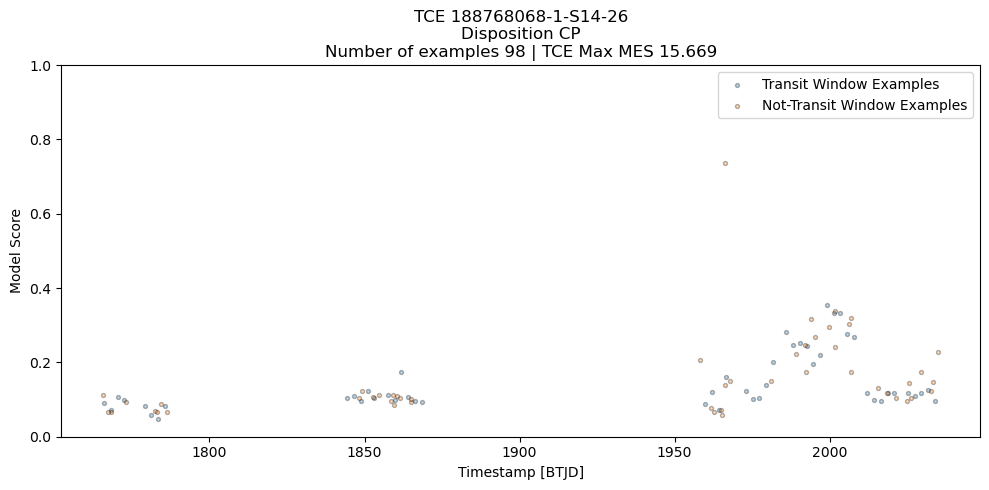

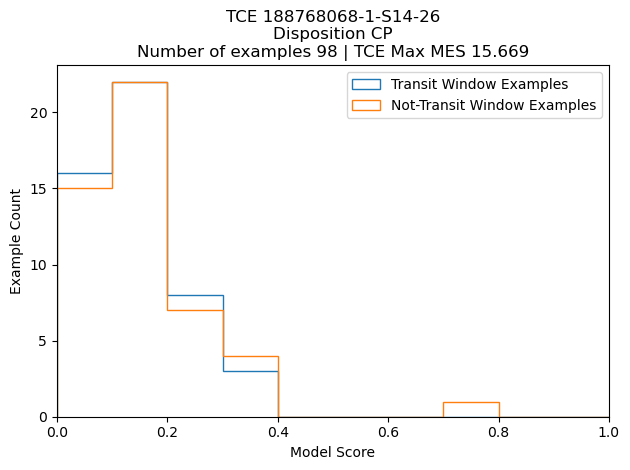

In [13]:
_plot_tce_ex_scatter_and_hist()

In [24]:
def _plot_tce_ex_pdcsap_lc_from_lk(uid, win_label, ex_plot_dir):
    global train_tbl

    sector_run = [s for s in (tce_uid.split('S')[-1].split('-'))]

    sector_arr = []

    if len(sector_run) > 1:
        sector_arr = list(range(int(sector_run[0]), int(sector_run[1]) + 1))
    else:
        sector_arr = [int(sector_run[0])]

    tce = tce_tbl.loc[tce_tbl["tce_uid"] == tce_uid]

    print(f"tic{tce['target_id'].values[0]}")
    print(f"sector_arr: {sector_arr}")

    # find light curve data for target
    search_lc_res = lk.search_lightcurve(
        target=f"tic{tce['target_id'].values[0]}",
        mission="TESS",
        author=("TESS-SPOC", "SPOC"),
        exptime=120,
        cadence="long",
        sector=sector_arr,
    )

    lcf = search_lc_res.download_all(
        download_dir=str(lc_dir), quality_bitmask="none", flux_column="pdcsap_flux"
    )

    def _lcf_masked_quantity_corrector(lcf: lk.LightCurve) -> lk.LightCurve:
        lcf = lk.LightCurve({"time": lcf.time.value, "flux": np.array(lcf.flux.value)})
        return lcf.normalize()

    try:
        print("tried stitch")
        lcf_stitched = lcf.stitch()
    except Exception as e:
        print(f"error: {e}")
        lcf_stitched = lcf.stitch(corrector_func=_lcf_masked_quantity_corrector)

    t0 = round(float(uid.split("_t_")[-1]), 3)

    examples_tce = train_tbl.loc[train_tbl["tce_uid"] == tce_uid]
    disp_tce = examples_tce["disposition"].values[0]

    dur_f = 5
    win_len = tce["tce_duration"].values[0] / 24 * dur_f

    t_start, t_end = t0 - win_len / 2, t0 + win_len / 2

    # Plot lcf
    f, ax = plt.subplots()
    lcf_stitched.plot(ax=ax)
    ax.set_xlim([t_start, t_end])
    ax.set_title(f"TCE {tce_uid} | Disposition {disp_tce}\nt0={t0} | True Label {win_label}")
    f.savefig(ex_plot_dir / f"plot_{tce_uid}_{disp_tce}_timestamp{t0}_label{win_label}.png")
    plt.show()
    plt.close()

In [25]:
# Plot norm example from shard
# tfrec_dir = Path("/Users/jochoa4/Desktop/studies/study_transfers/study_model_preds_05-22-2025/tfrecords/")
# tfrec_fp = tfrec_dir / "norm_train_shard_2990-8611.tfrecord"

def _plot_tce_ex_lc_diff_imgs_from_tfrec(uid, ex_plot_dir):
    if tfrec_fp:
        assert tfrec_fp.exists(), f"ERROR: tfrec_fp {tfrec_fp} does not exist"

        # t0 = ex_uid.split("_t_")[-1]

        # uid_pattern = f"{tce_uid}_t_{str(t0)}"
        src_tfrecord_dataset = tf.data.TFRecordDataset(tfrec_fp)

        # def _plot_tce_example(src_tfrecord_dataset, t0, uid_pattern):

        ex_flux = []
        ex_diff_imgs = []
        ex_label = None
        ex_snr = None
        ex_t = None

        # Load source dataset
        found_example = False

        for string_record in src_tfrecord_dataset.as_numpy_iterator():

            example = tf.train.Example()

            example.ParseFromString(string_record)

            example_uid = example.features.feature["uid"].bytes_list.value[0].decode("utf-8")

            if uid == example_uid:
                # flux
                ex_flux = example.features.feature[
                    "flux_norm"
                ].float_list.value

                # diff imgs
                for img_feature in ["diff_img_stdnorm", "oot_img_stdnorm", "snr_img_stdnorm", "target_img"]:
                    example_img_feature = tf.reshape(
                        tf.io.parse_tensor(
                            example.features.feature[img_feature].bytes_list.value[0],
                            tf.float32,
                        ),
                        (33, 33),
                    ).numpy()
                    ex_diff_imgs.append(example_img_feature)
                    
                ex_label = example.features.feature["label"].bytes_list.value[0].decode("utf-8")
                # ex_disposition = example.features.feature["disposition"].bytes_list.value[0].decode("utf-8")


                ex_snr = example.features.feature[
                "tce_model_snr"
            ].float_list.value[0]
                
                ex_t = example.features.feature[
                "t"
            ].float_list.value[0]
                found_example = True
                break

        assert found_example, f"ERROR: did not find example matching uid {uid}"

        flux_curve = ex_flux
        diff_img, oot_img, snr_img, target_img = ex_diff_imgs
        snr = ex_snr
        midpoint = ex_t
        norm = True
        

        label = "In Transit" if ex_label == "1" else "Out of Transit"
        snr = str(round(snr, 2))
        it_idx = np.argmax(target_img)
        row, col = np.unravel_index(
            it_idx, target_img.shape
        )  # Get row and col as if array were flattened
        target_coords = {"x": row, "y": col}

        fig = plt.figure(figsize=(16, 16))

        gs = gridspec.GridSpec(3, 2, figure=fig)

        ax = fig.add_subplot(gs[0, :])
        time = np.linspace(0, 100, 100)
        ax.plot(time, flux_curve, color="b", marker="o", linewidth=0)#"b-", linewidth=2, marker="o", markersize=3, alpha=0.6)

        ax.set_title(f"{label} Flux Curve w/ midpoint {round(midpoint,2)} Over Time")
        ax.set_xlabel("Time")
        ax.set_ylabel("Flux value") if not norm else ax.set_ylabel("Normalized Flux value")

        # diff img
        ax = fig.add_subplot(gs[1, 0])
        im = ax.imshow(diff_img, norm=None)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        ax.scatter(
            target_coords["y"], target_coords["x"], marker="x", color="r", label="Target"
        )
        ax.set_ylabel("Row")
        ax.set_xlabel("Col")
        ax.legend()
        (
            ax.set_title("Difference Flux (e-/cadence)")
            if not norm
            else ax.set_title("Normalized Difference Flux")
        )
        # oot img
        ax = fig.add_subplot(gs[1, 1])
        im = ax.imshow(oot_img, norm=LogNorm() if not norm else None)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        ax.scatter(
            target_coords["y"], target_coords["x"], marker="x", color="r", label="Target"
        )
        ax.set_ylabel("Row")
        ax.set_xlabel("Col")
        ax.legend()
        (
            ax.set_title("Out-of-Transit Flux (e-/cadence)")
            if not norm
            else ax.set_title("Normalized Out-of-Transit Flux")
        )
        # target img
        ax = fig.add_subplot(gs[2, 0])
        ax.imshow(target_img)
        ax.set_ylabel("Row")
        ax.set_xlabel("Col")
        ax.set_title("Target Position")
        # snr img
        ax = fig.add_subplot(gs[2, 1])
        im = ax.imshow(snr_img, norm=LogNorm() if not norm else None)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        ax.scatter(
            target_coords["y"], target_coords["x"], marker="x", color="r", label="Target"
        )
        ax.set_ylabel("Row")
        ax.set_xlabel("Col")
        ax.legend()
        (
            ax.set_title(f"Difference SNR: {snr}")
            if not norm
            else ax.set_title(f"Normalized Difference SNR: {snr}")
        )

        plt.tight_layout()
        plt.savefig(ex_plot_dir / f"plot_tfrec_{tce_uid}_{disp_tce}_timestamp{round(ex_t, 3)}_label{ex_label}.png")
        plt.show()
        plt.close()

In [26]:
def _confusion_category(row):
    if row["label"] == 1 and row["bin_pred"] == 1:
        return "TP"
    elif row["label"] == 0 and row["bin_pred"] == 1:
        return "FP"
    elif row["label"] == 0 and row["bin_pred"] == 0:
        return "TN"
    elif row["label"] == 1 and row["bin_pred"] == 0:
        return "FN"
    
train_tbl["confusion"] = train_tbl.apply(_confusion_category, axis=1)
train_tbl["cf_pred_percentile"] = train_tbl.groupby("confusion")["raw_pred"].rank(pct=True)
train_tbl["cf_pred_band"] = (train_tbl["cf_pred_percentile"] * 10).astype(int) # 20 bins, 0-19
train_tbl["cf_pred_band_label"] = train_tbl["cf_pred_band"].apply(lambda x: f"{x*10}-{(x+1)*10}%") # rename

In [27]:
tce_df = train_tbl[train_tbl["tce_uid"] == tce_uid]

# Sample up to 2 examples per prediction band percentile (ie 10-20%) within confusion_label/cf_pred-band groups
sampled_tces = (tce_df.groupby(["confusion", "cf_pred_band"])
            .apply(lambda group: group.sample(n=min(2, len(group)), random_state=42))
            .reset_index(drop=True)
            )
sampled_tces
sampled_tces.to_csv(str(tce_plot_dir / f"sampled_tce_{tce_uid}_percentile_info.csv"))

In [28]:
def _find_first_epoch_after_this_time(epoch, period, reference_time):
    """ Finds the first epoch after a certain reference time.

    :param epoch: float initial epoch value (days)
    :param period: float, period (days)
    :param reference_time: float, start reference time (days)
    :return:
        tepoch: float, new epoch value

    # Code is ported from Jeff Smith's Matlab ephemeris matching code
    """

    if epoch < reference_time:
        tepoch = epoch + period * np.ceil((reference_time - epoch) / period)
    else:
        tepoch = epoch - period * np.floor((epoch - reference_time) / period)

    return tepoch

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

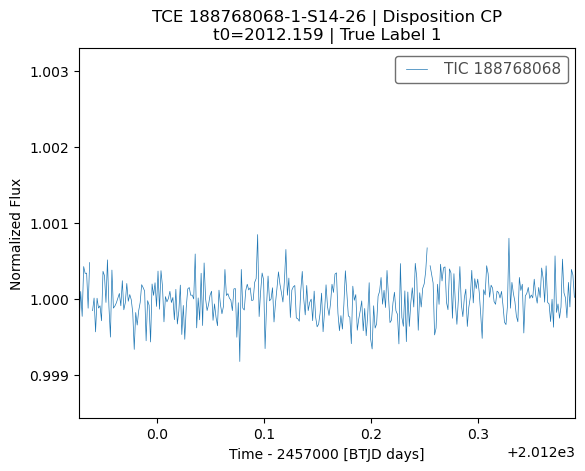

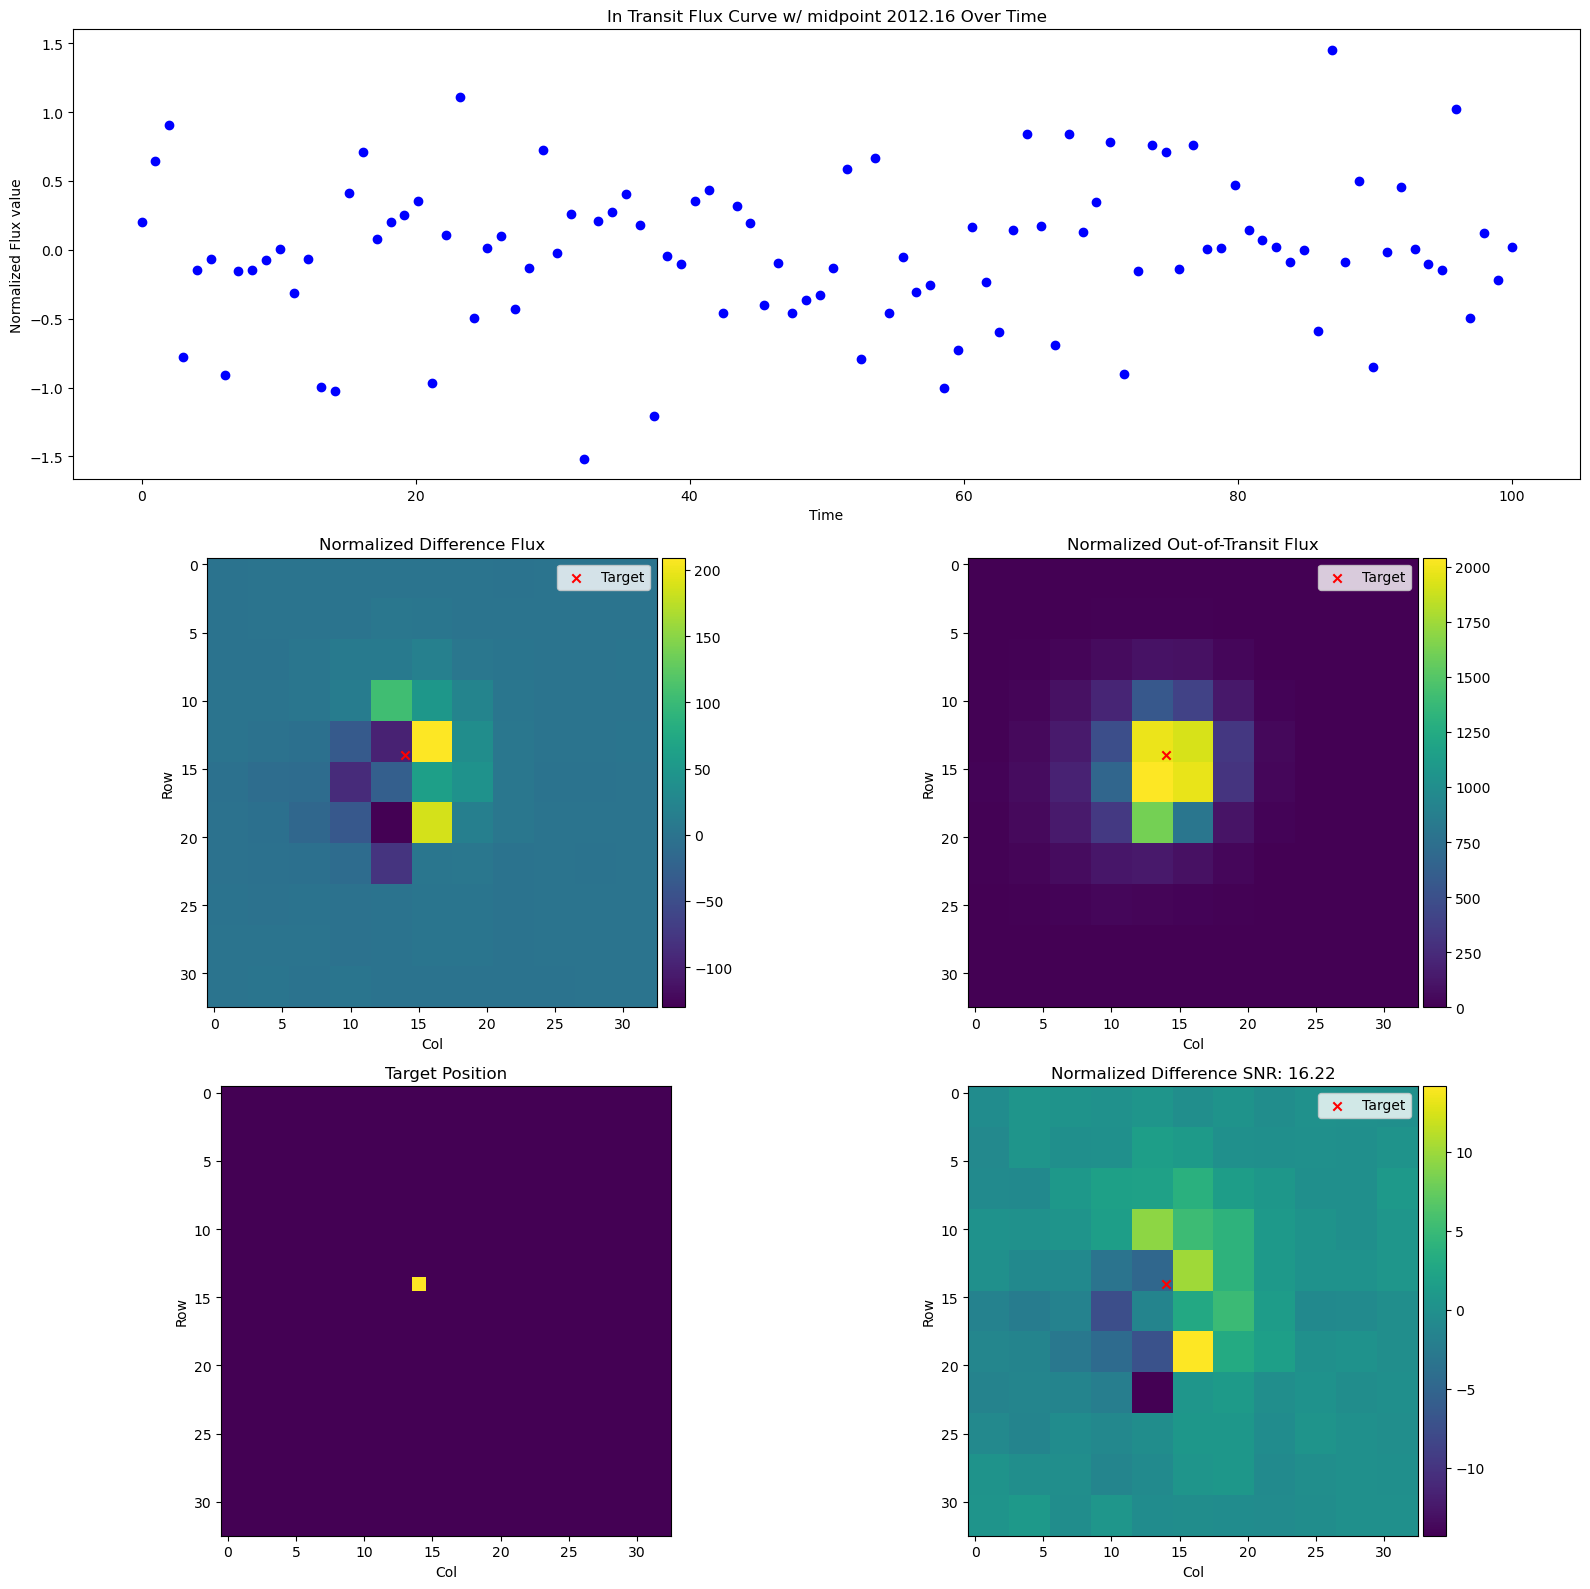

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

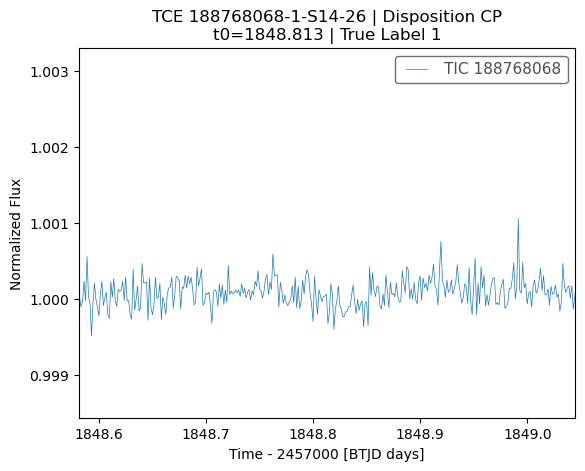

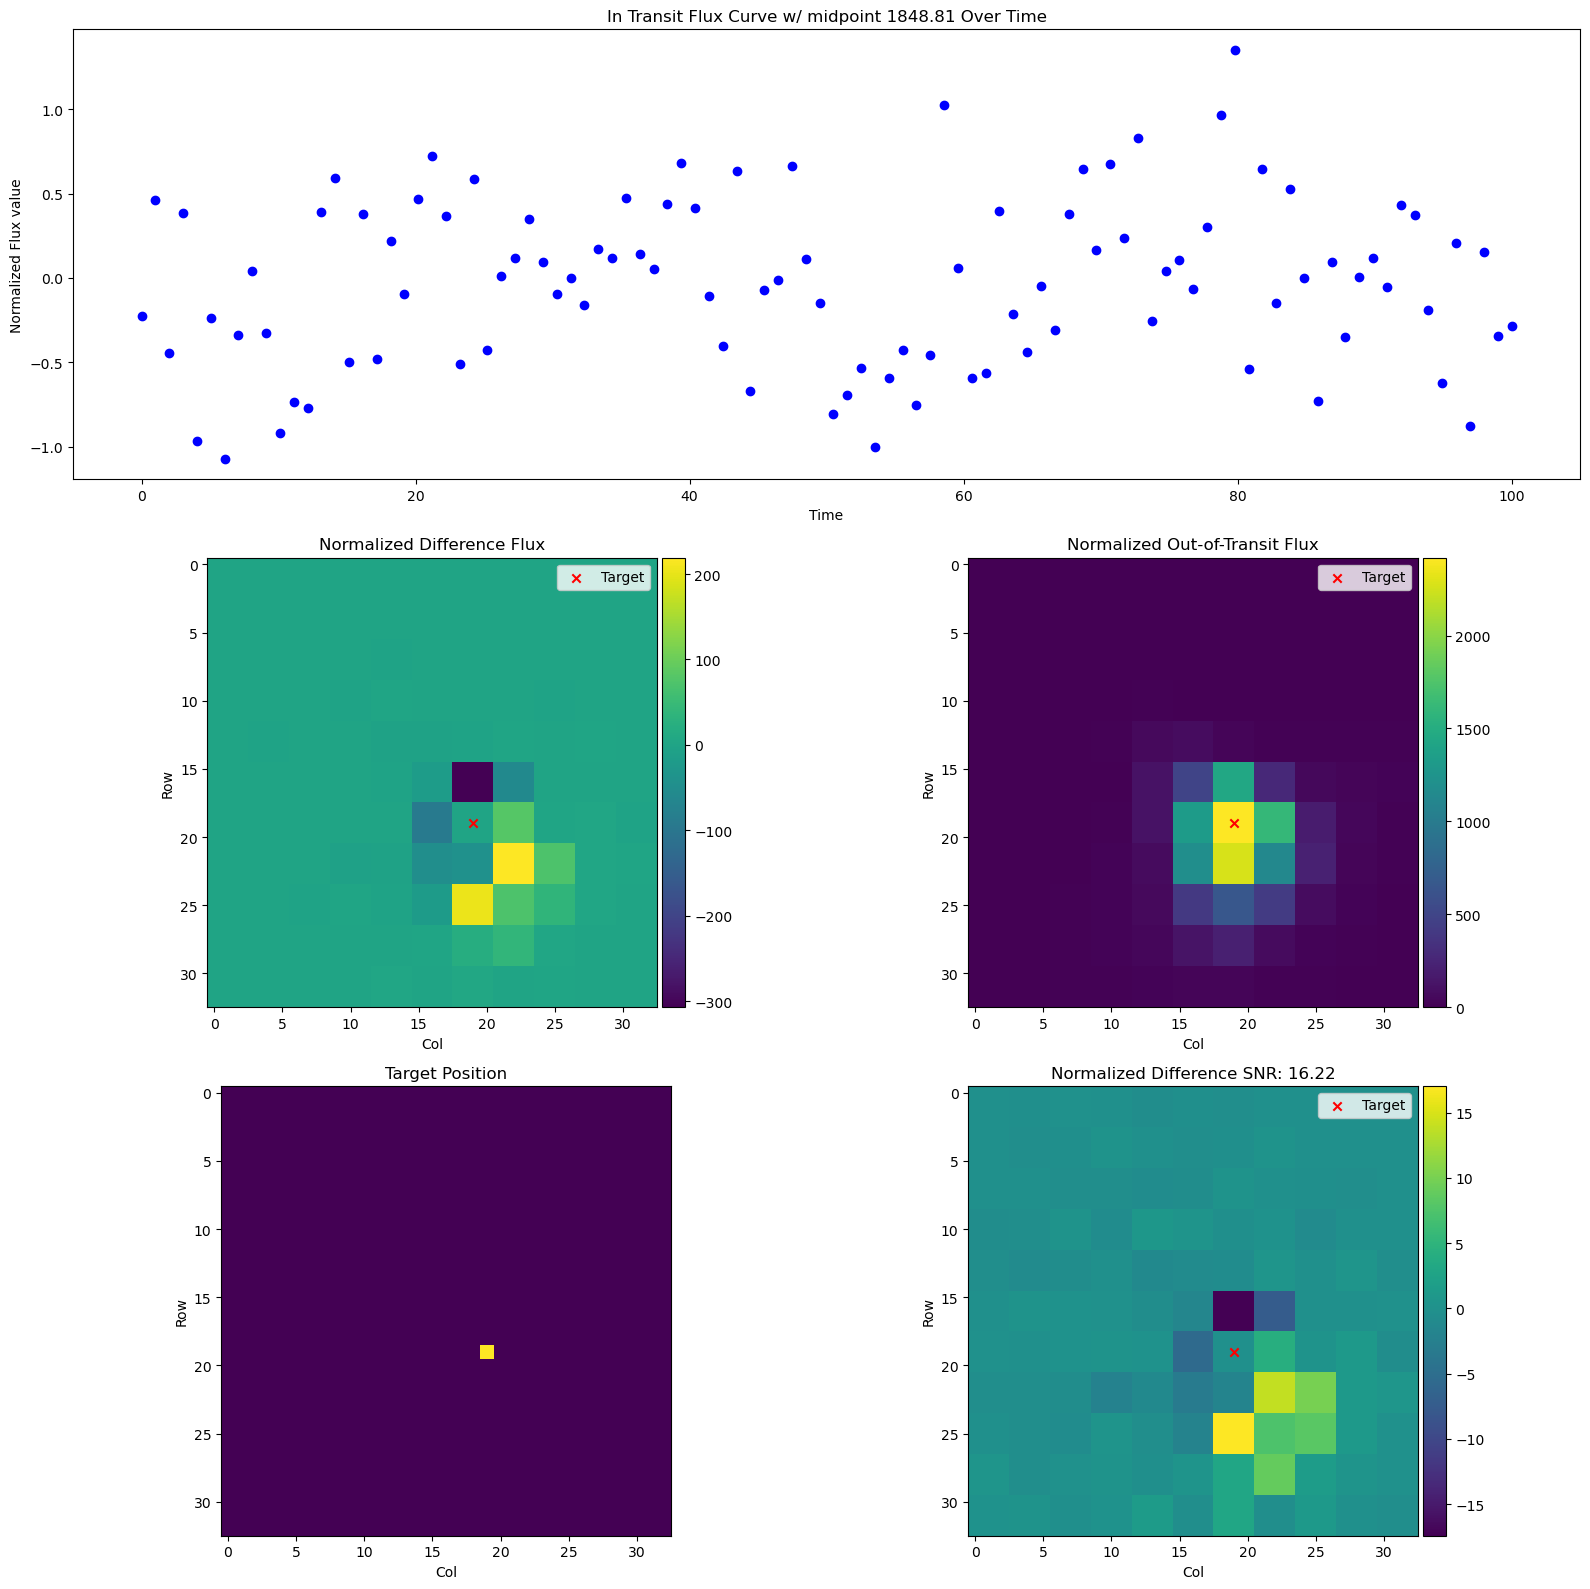

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

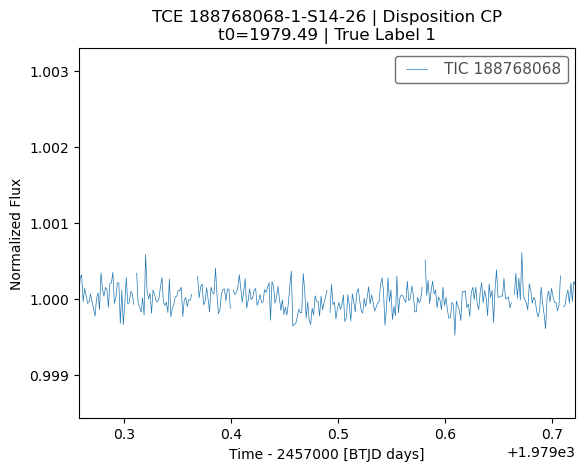

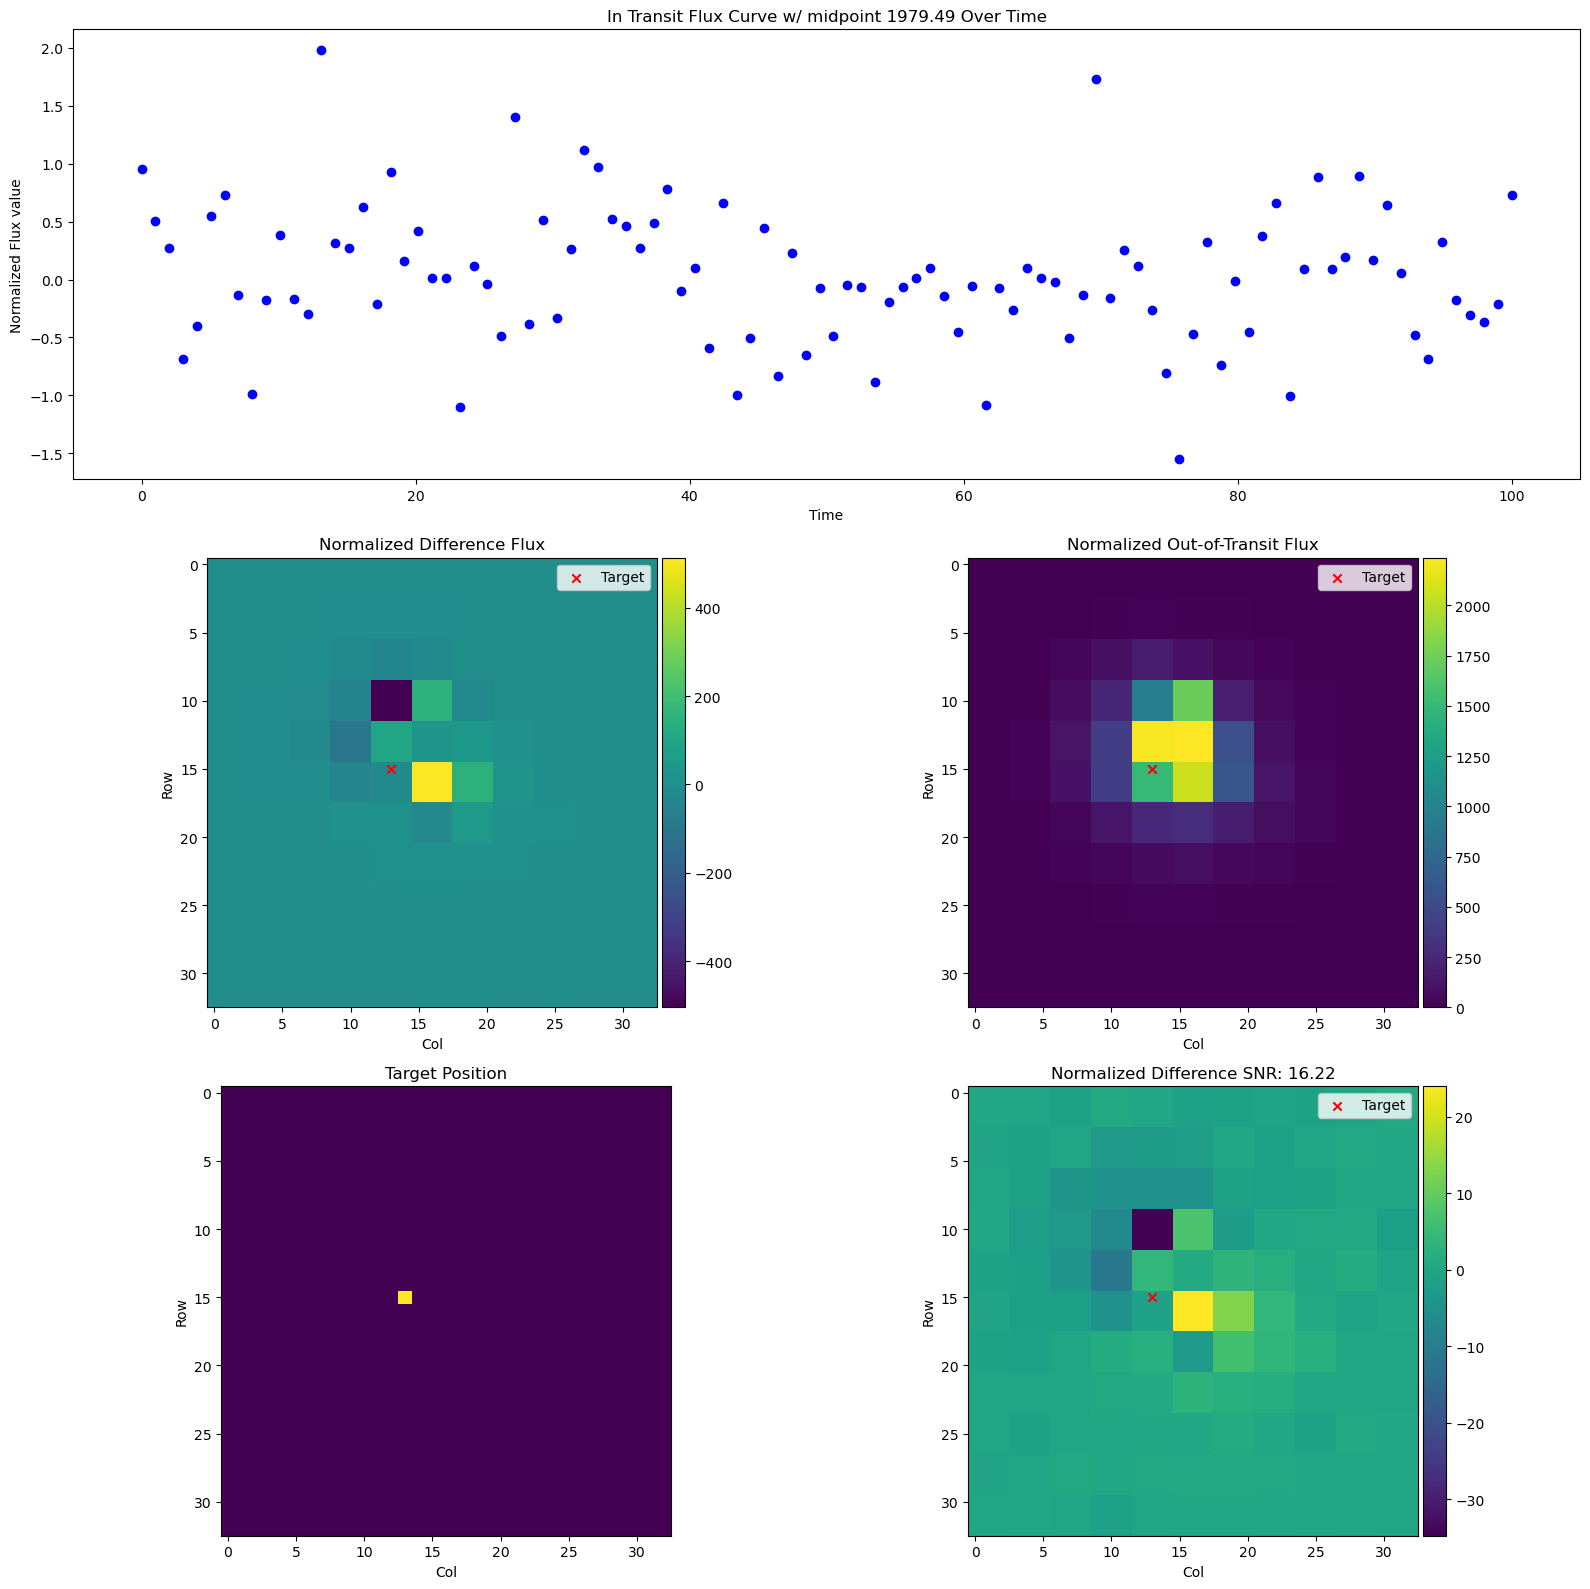

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

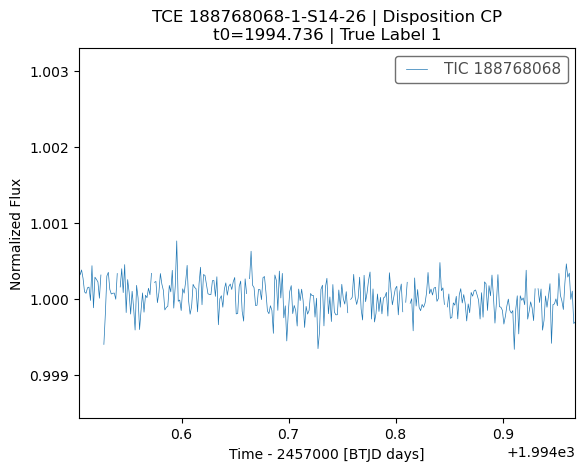

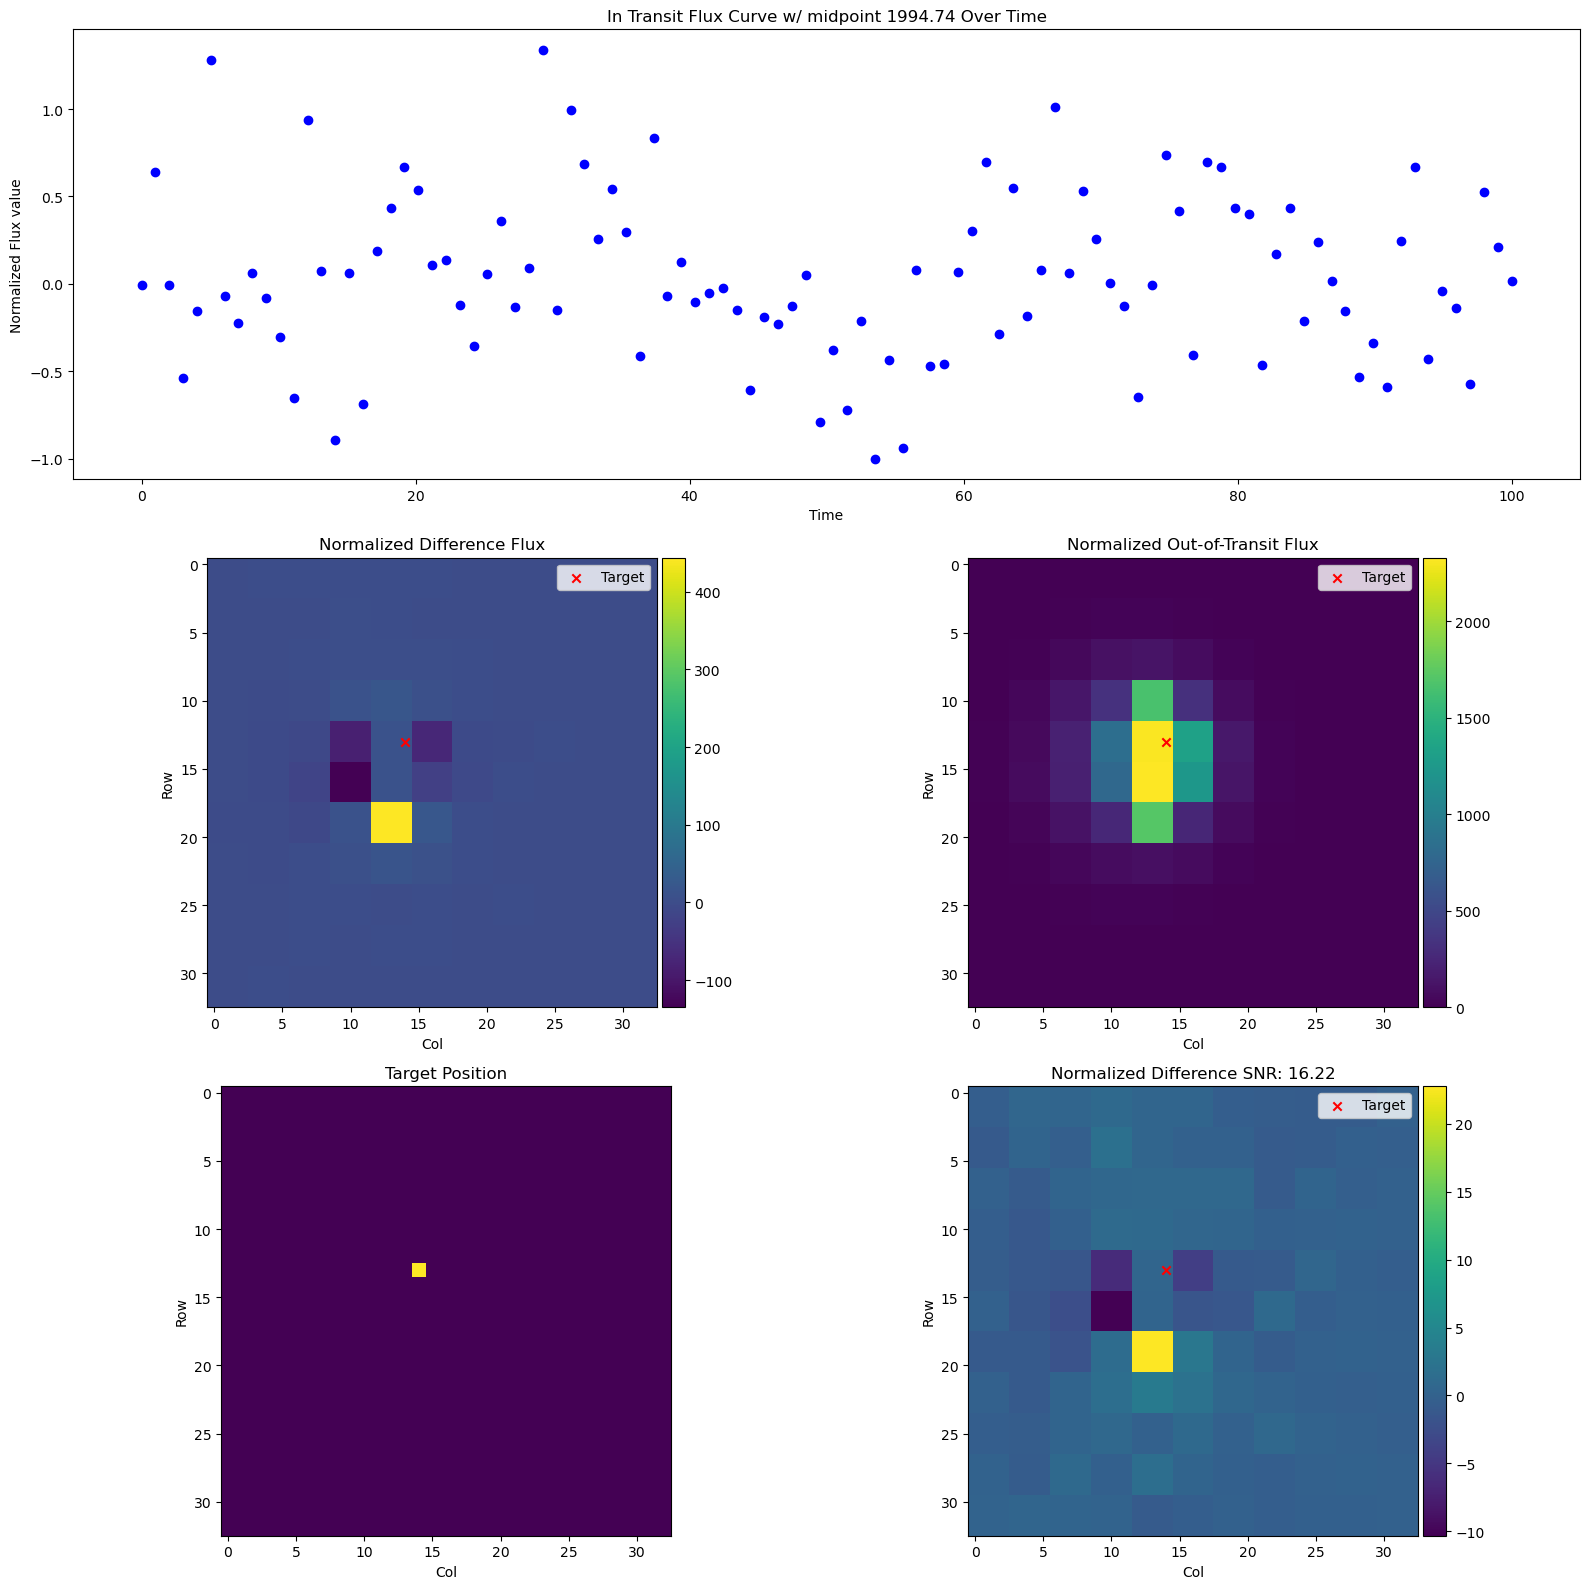

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

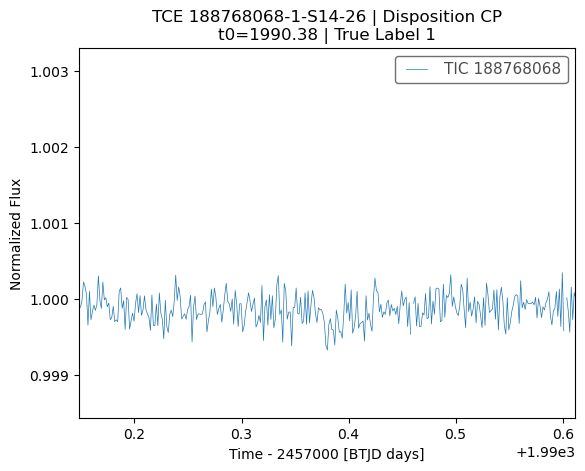

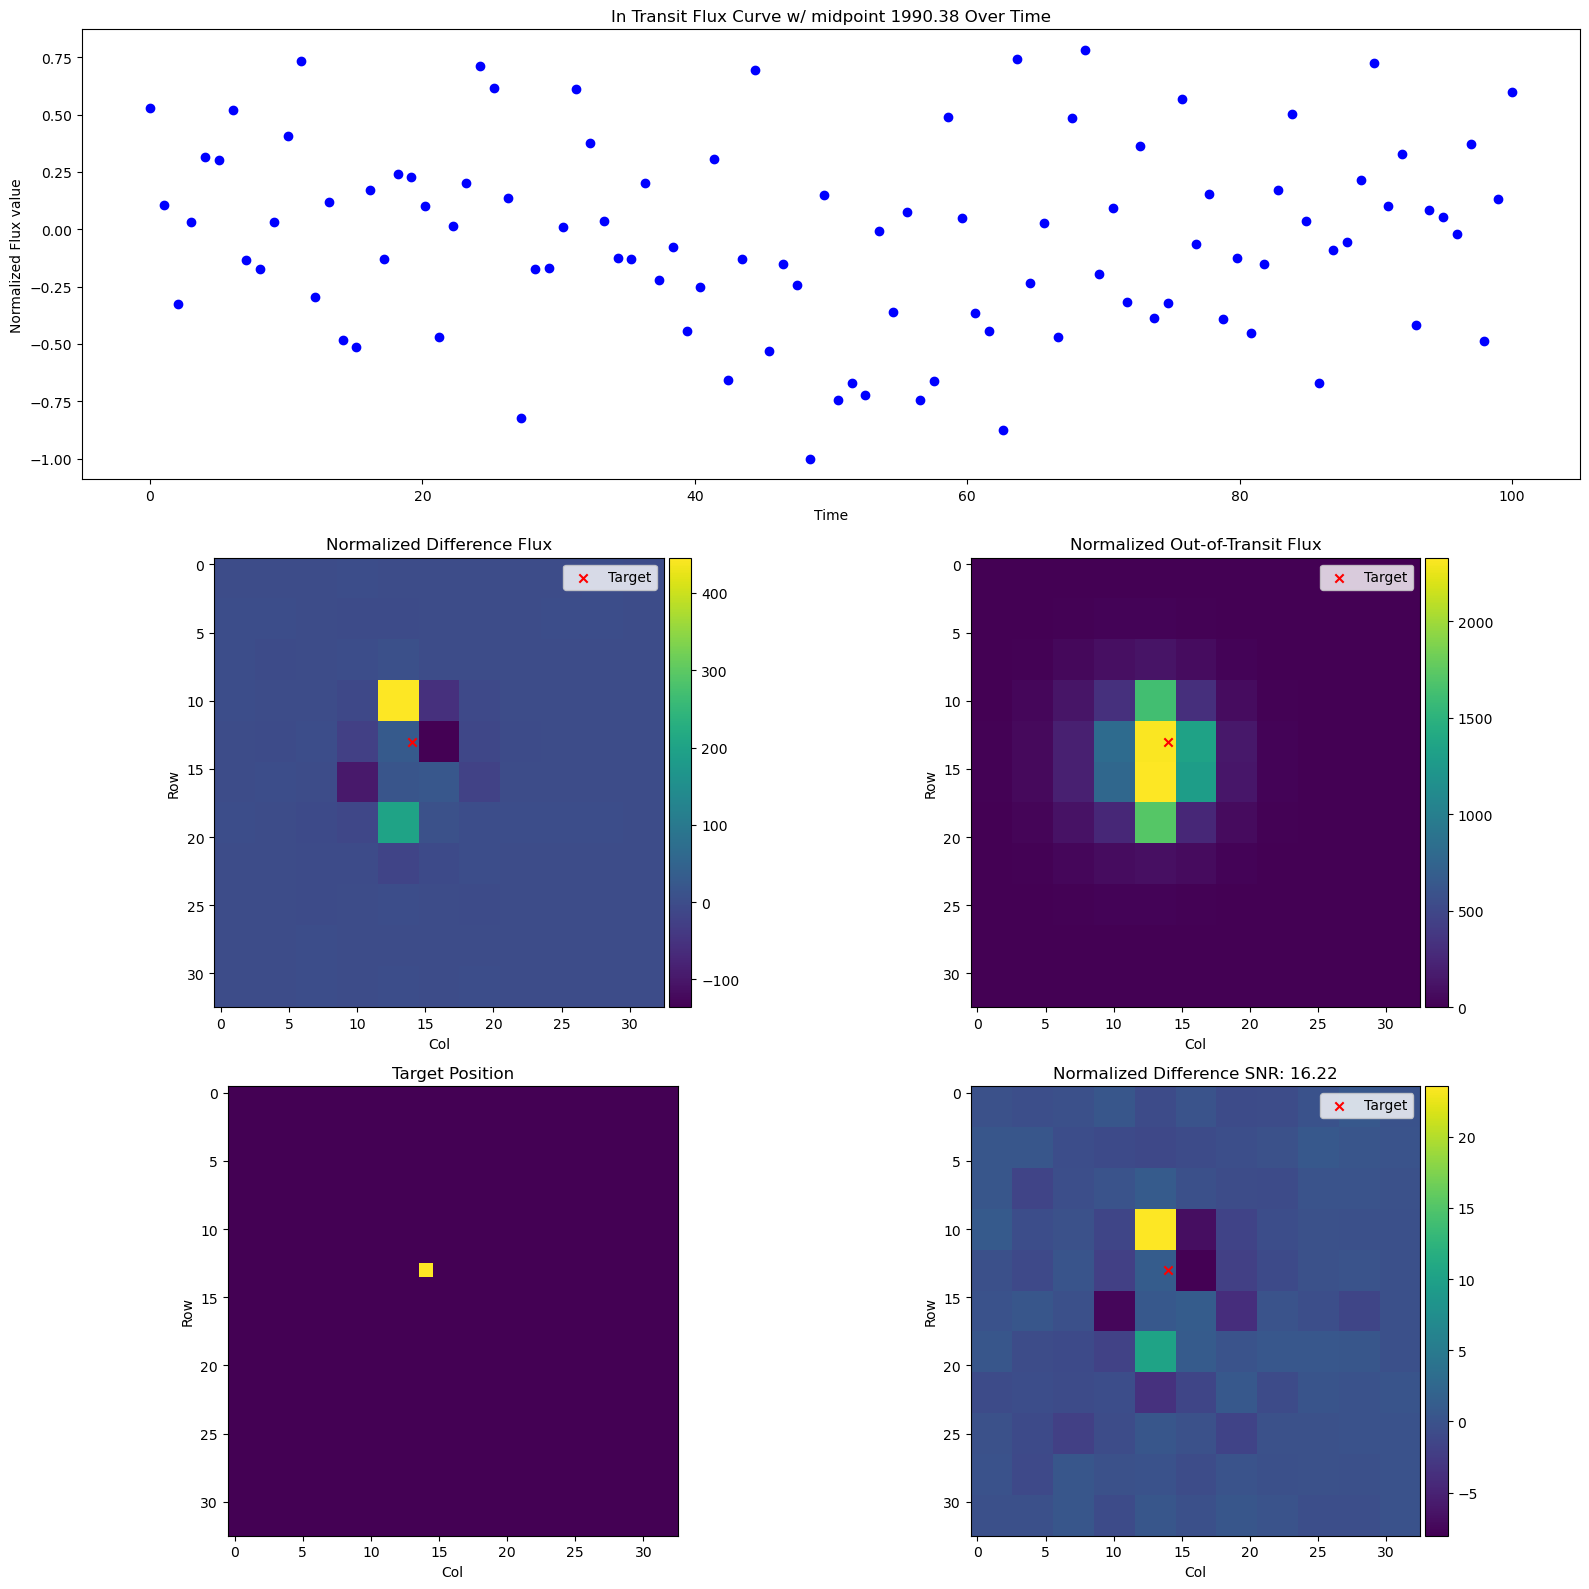

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

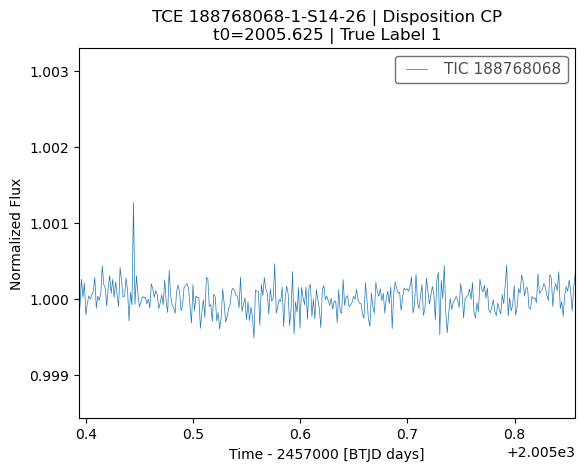

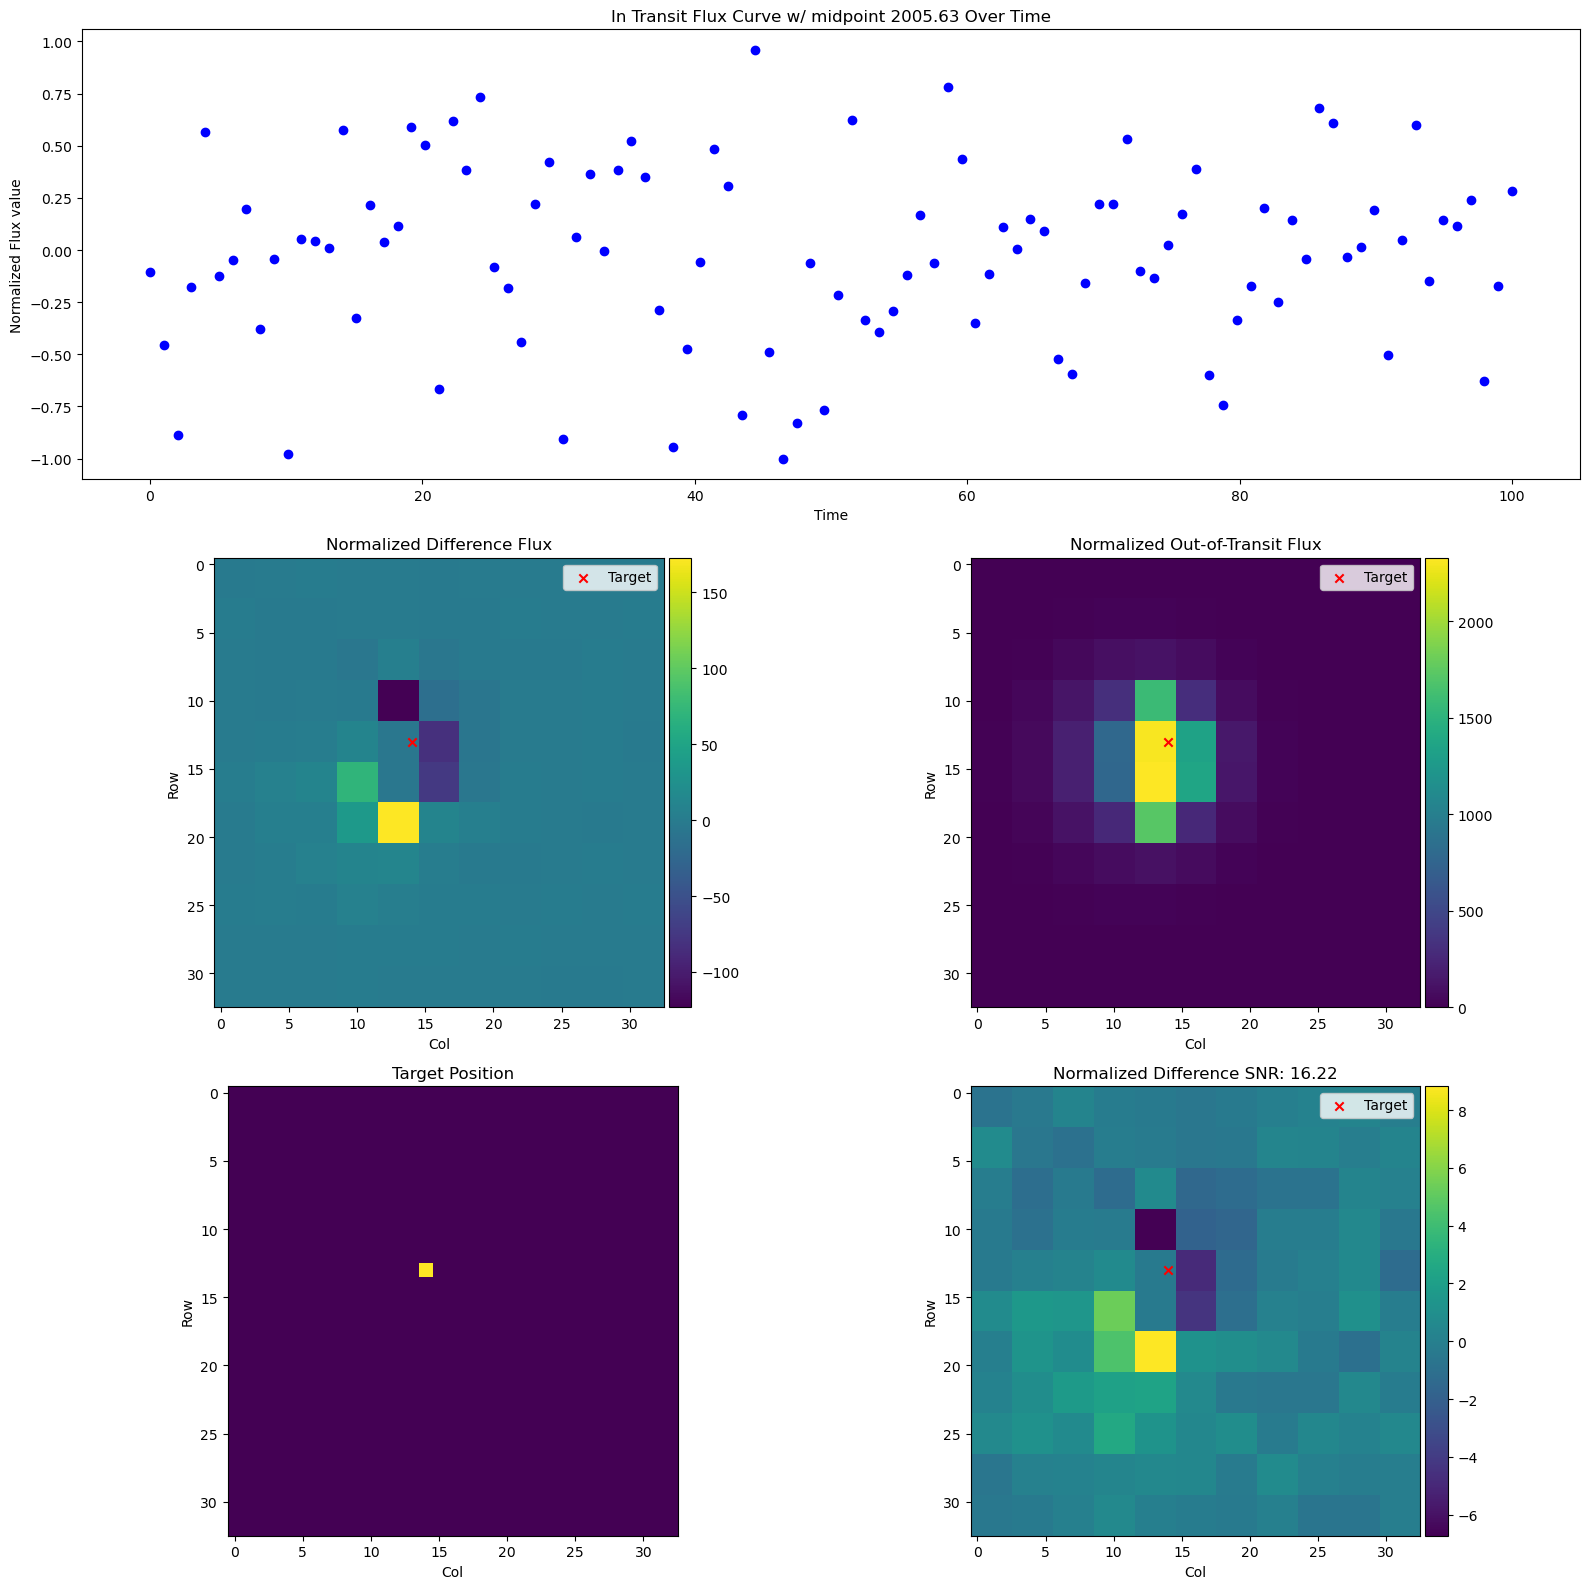

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

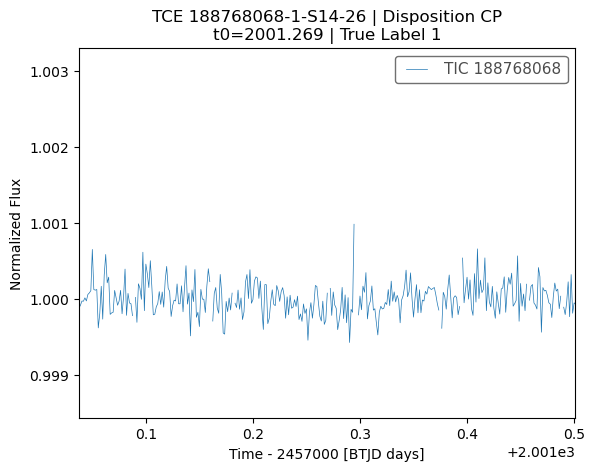

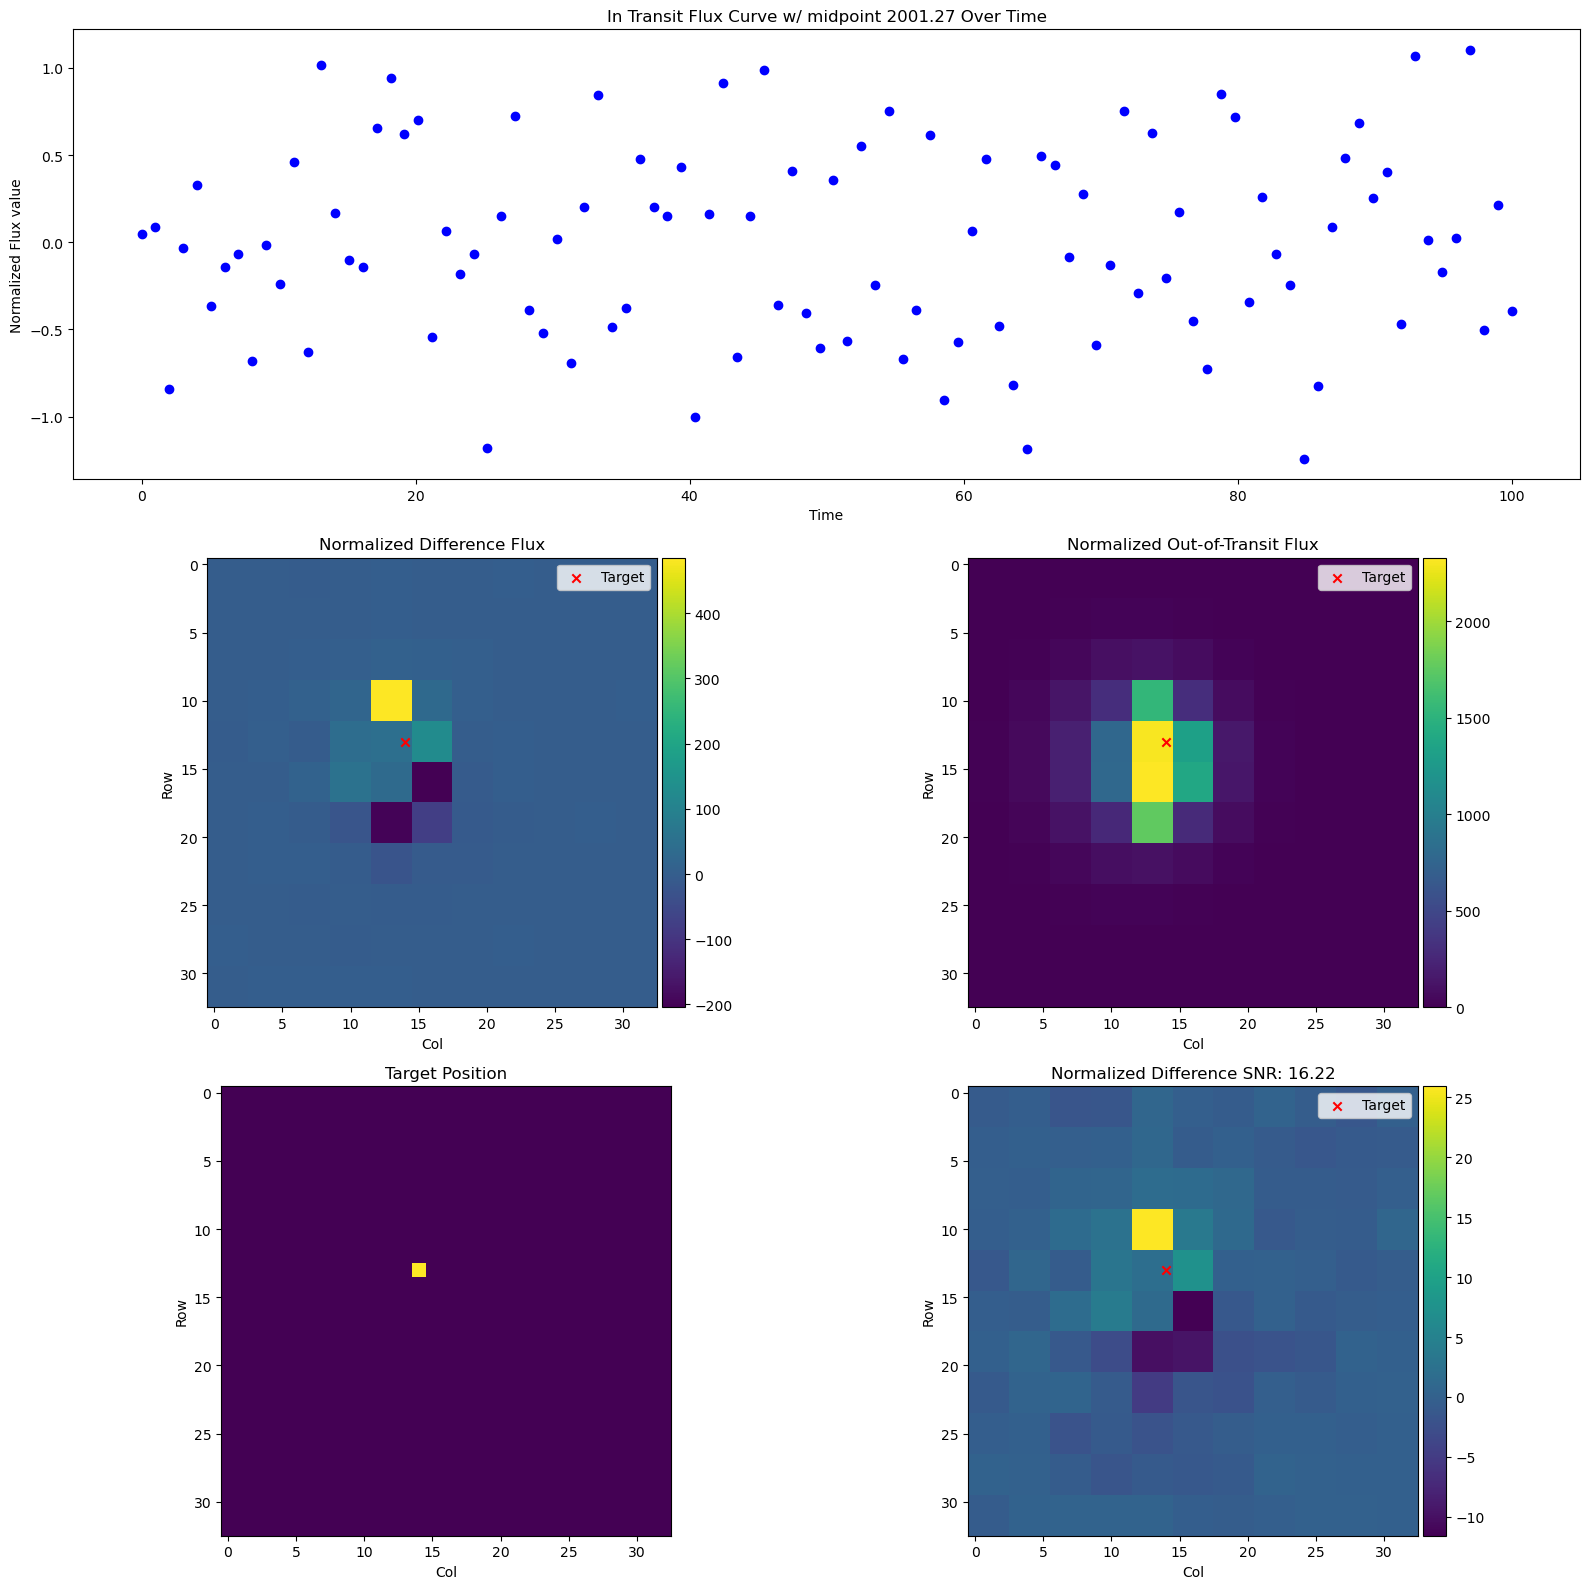

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

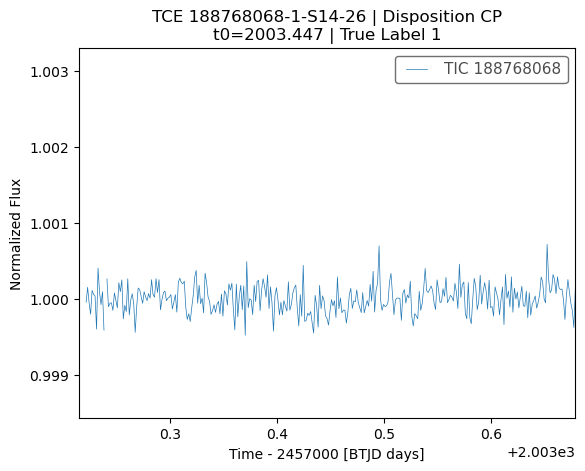

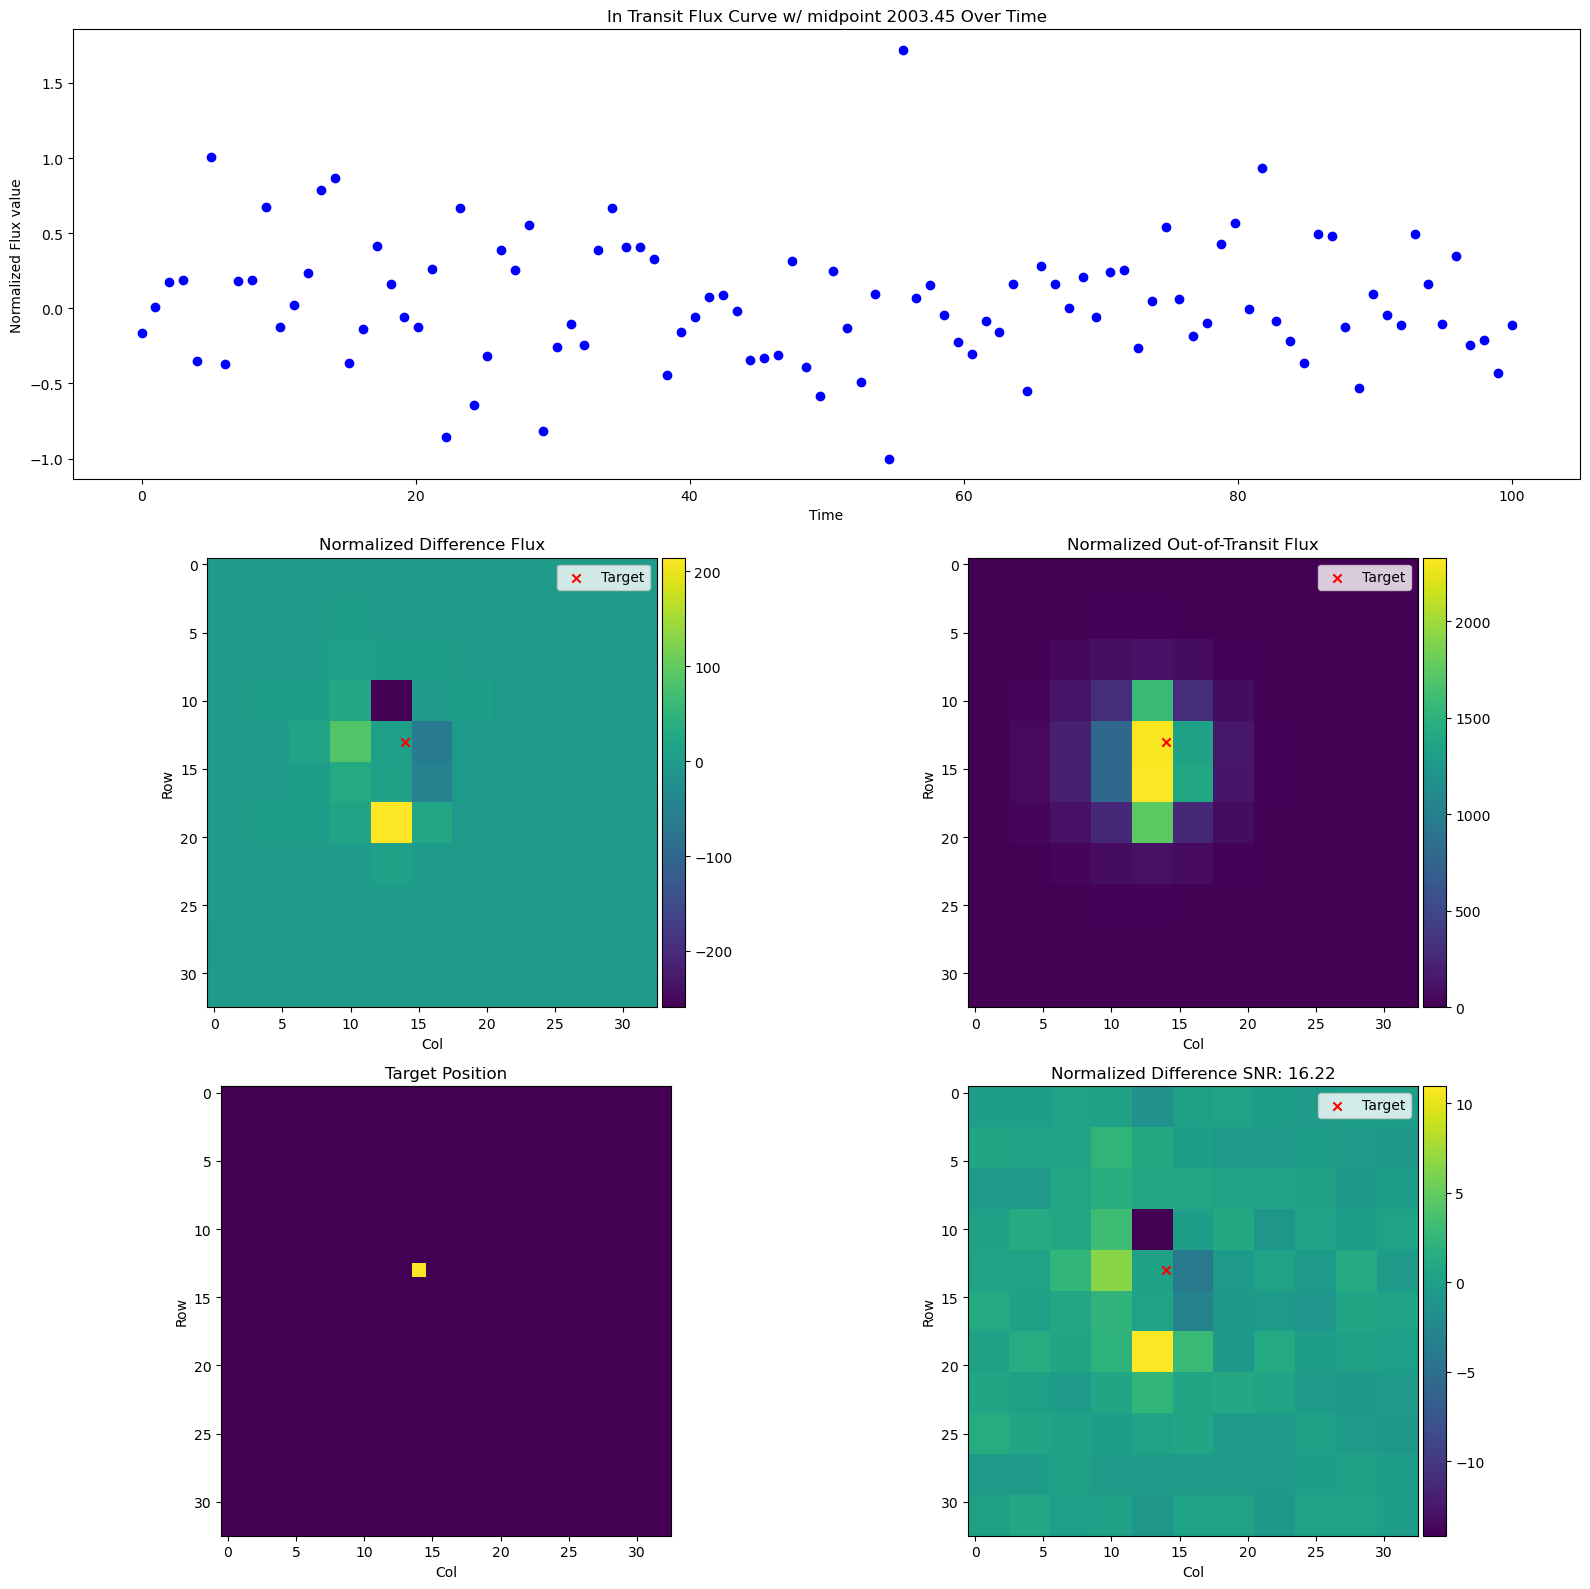

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

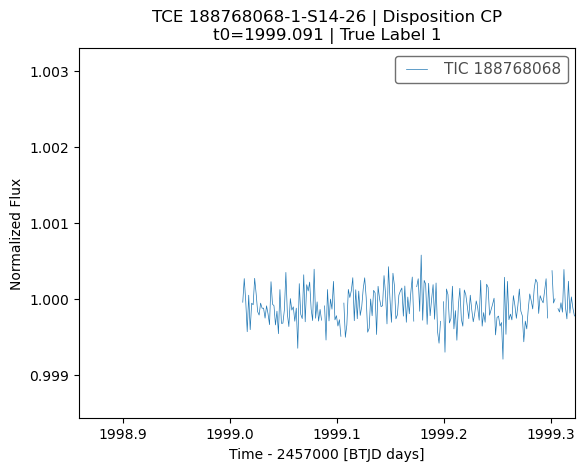

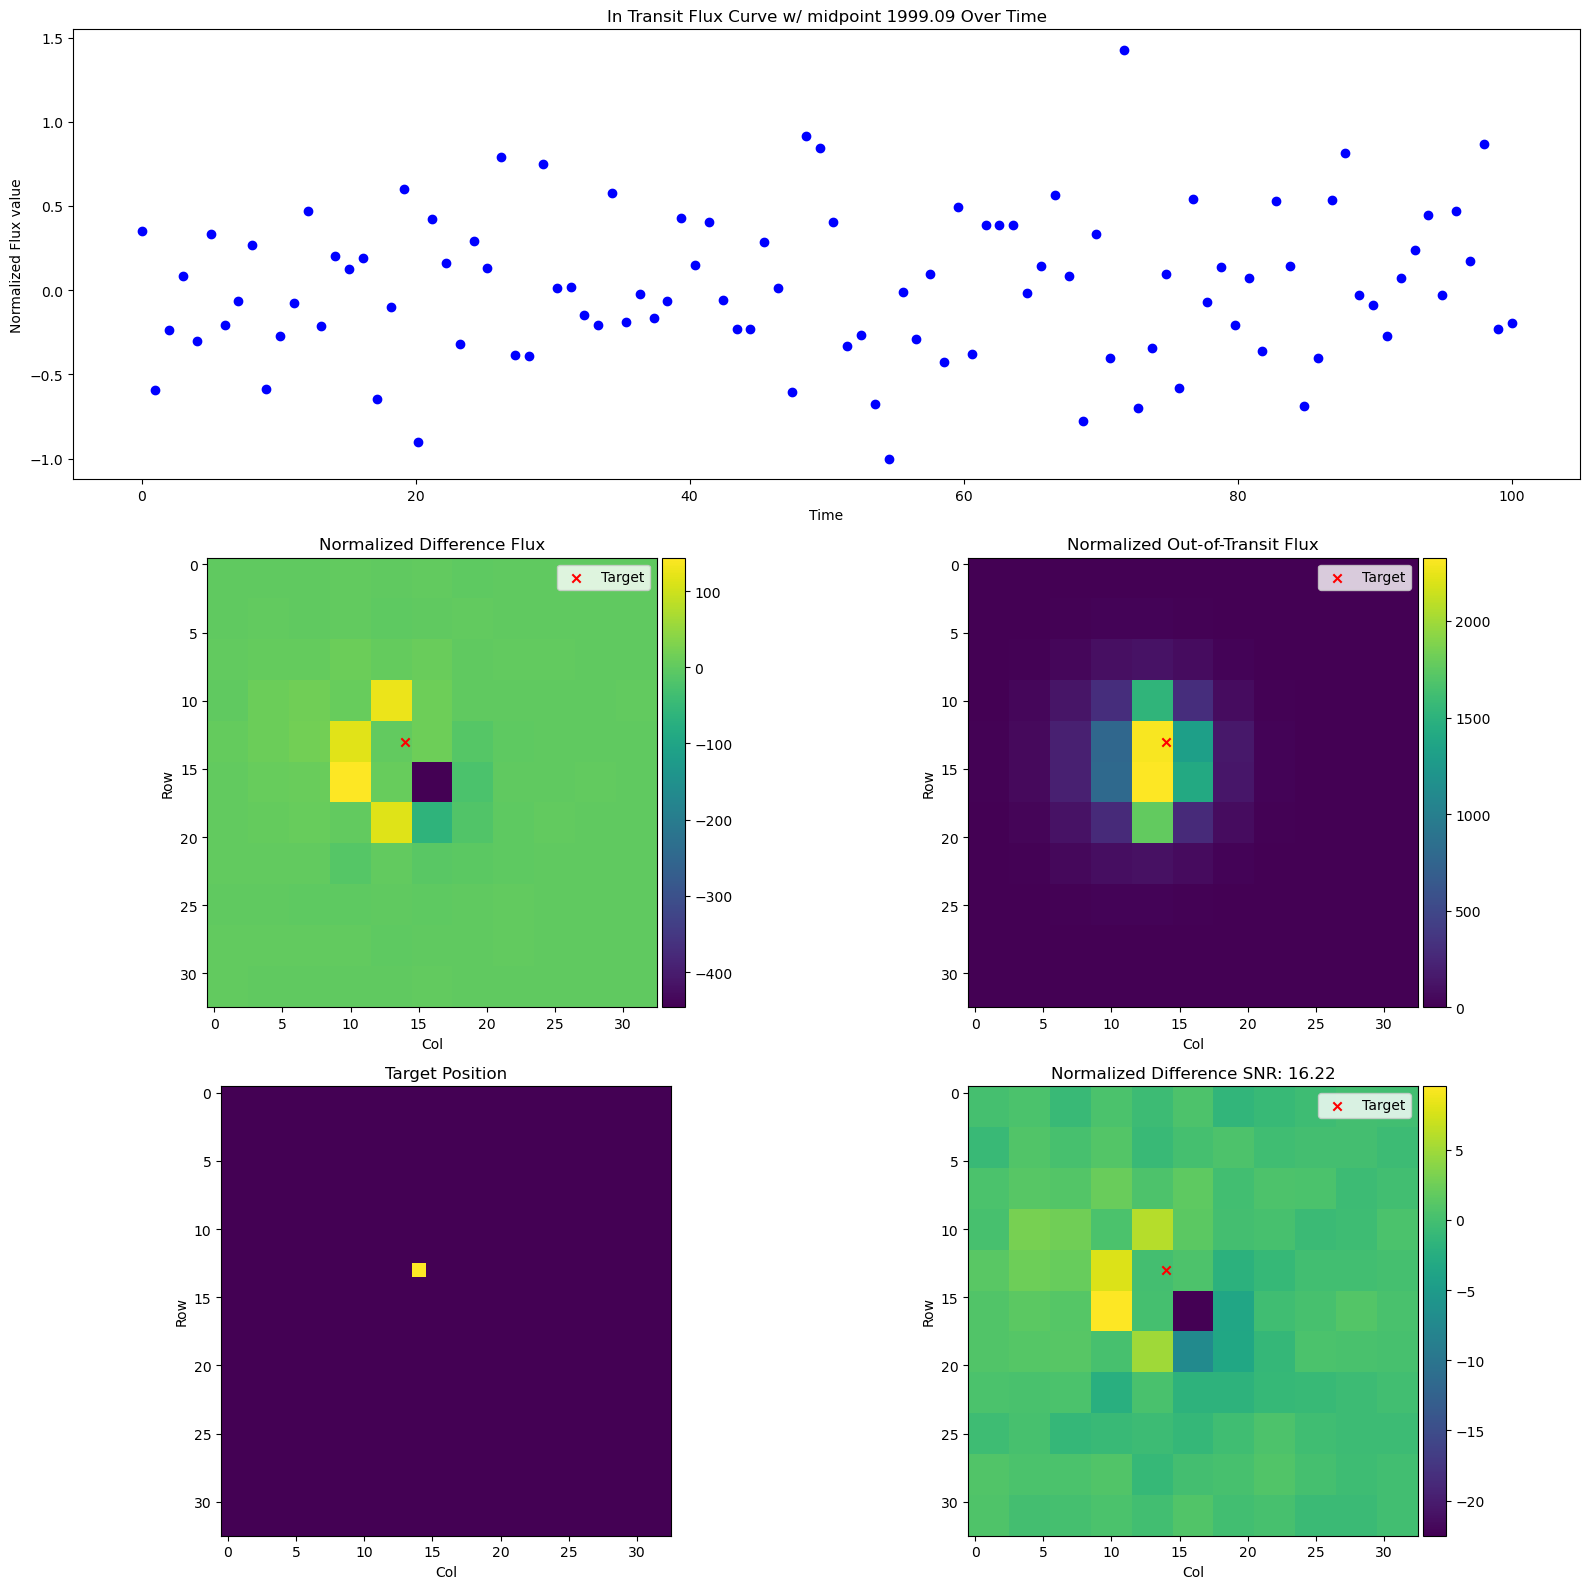

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

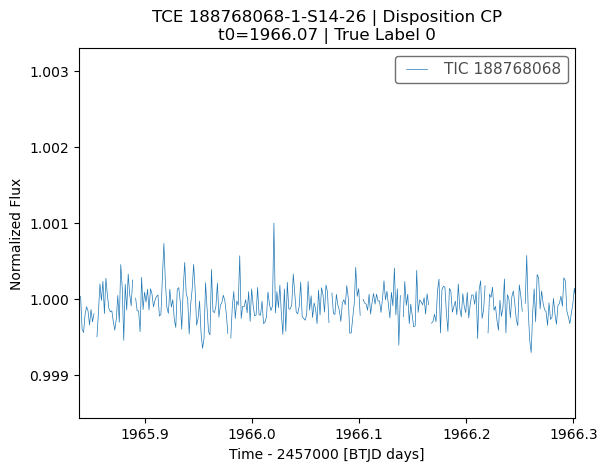

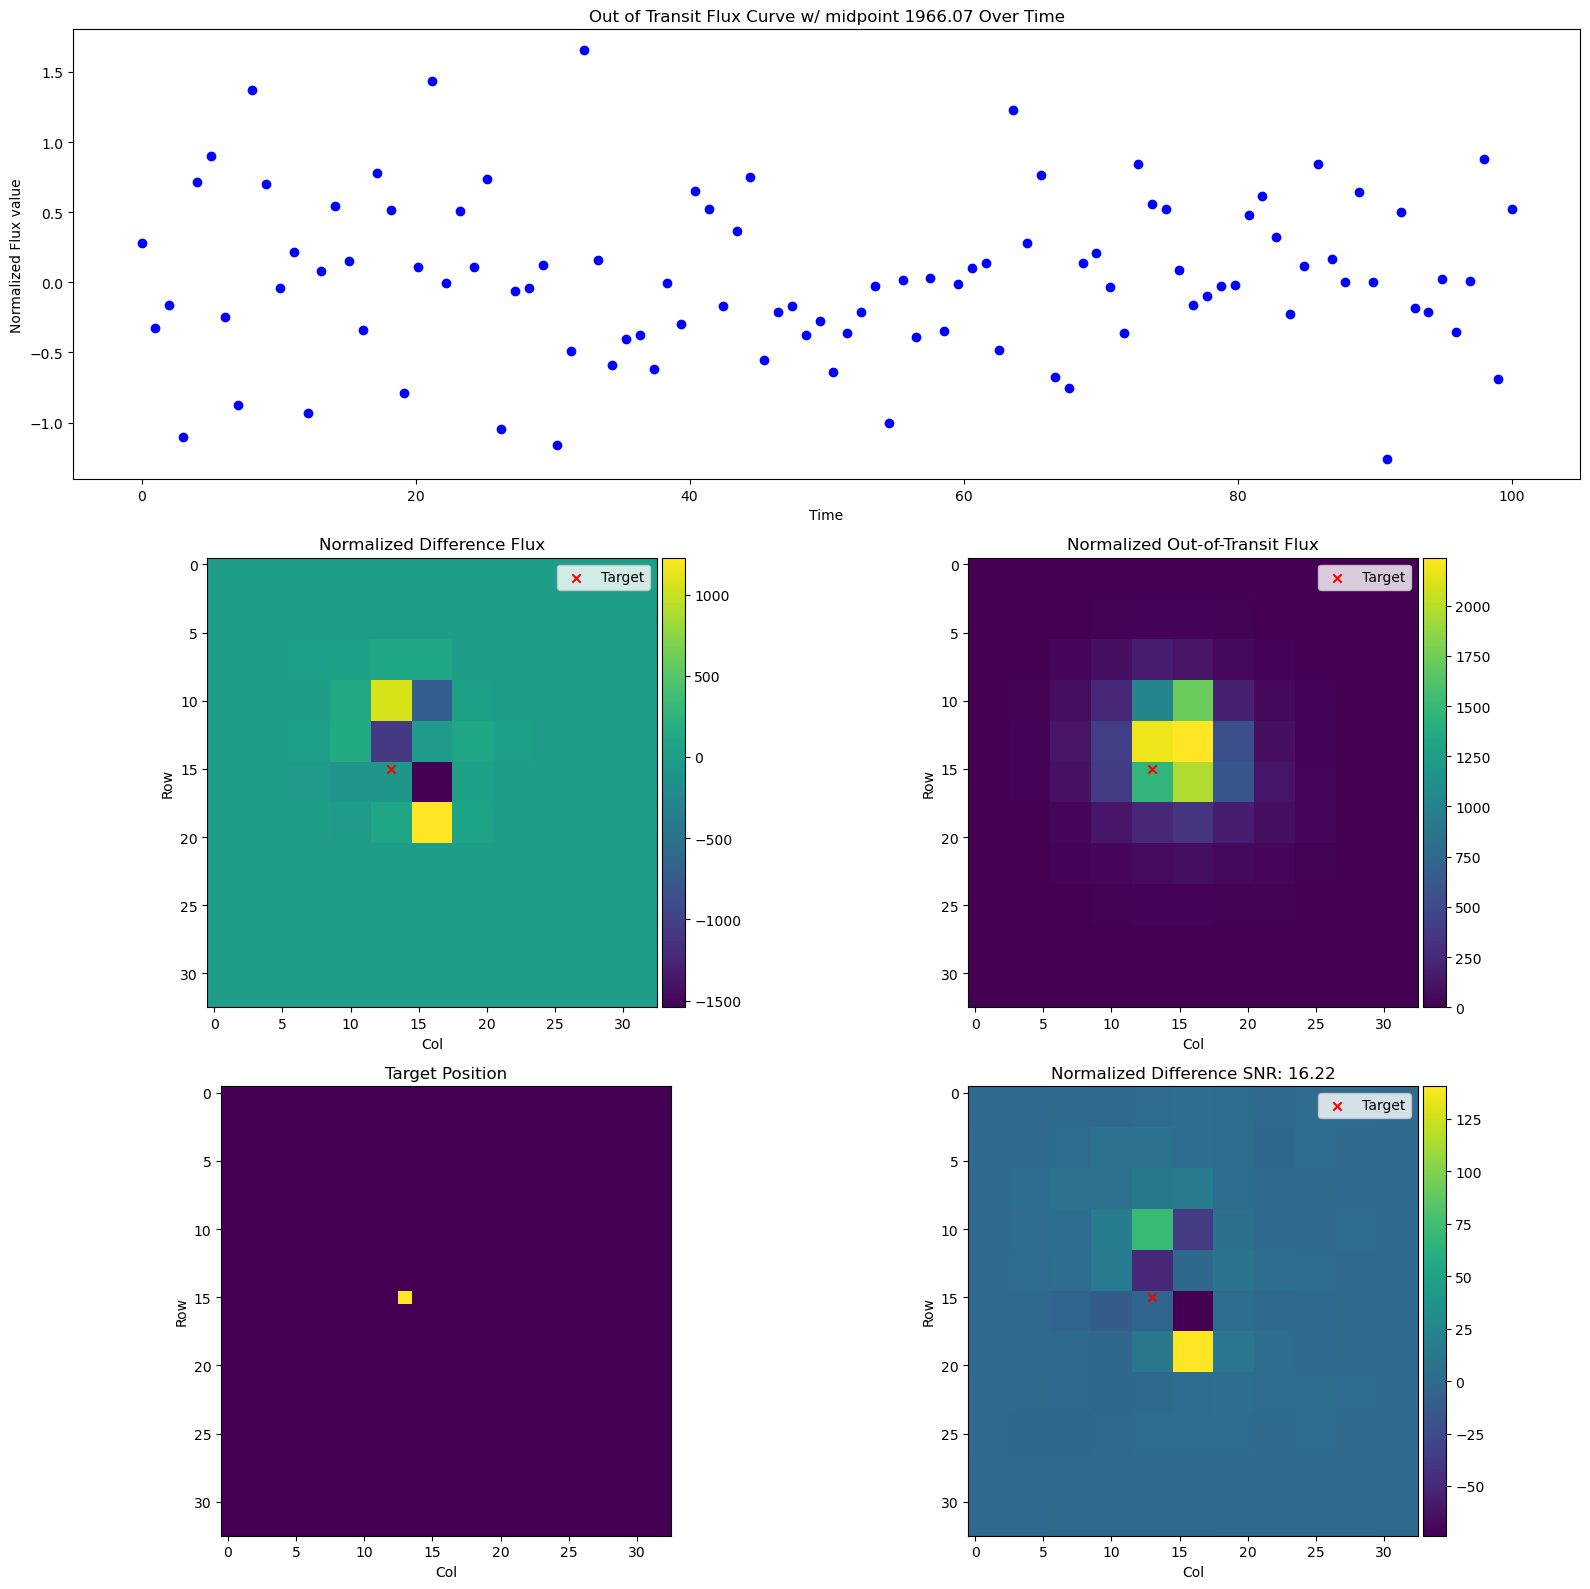

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

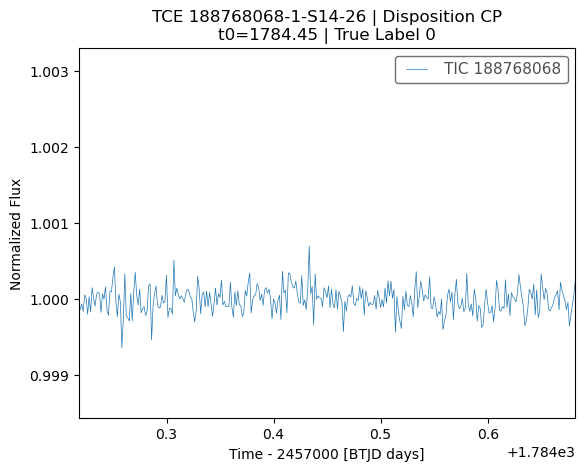

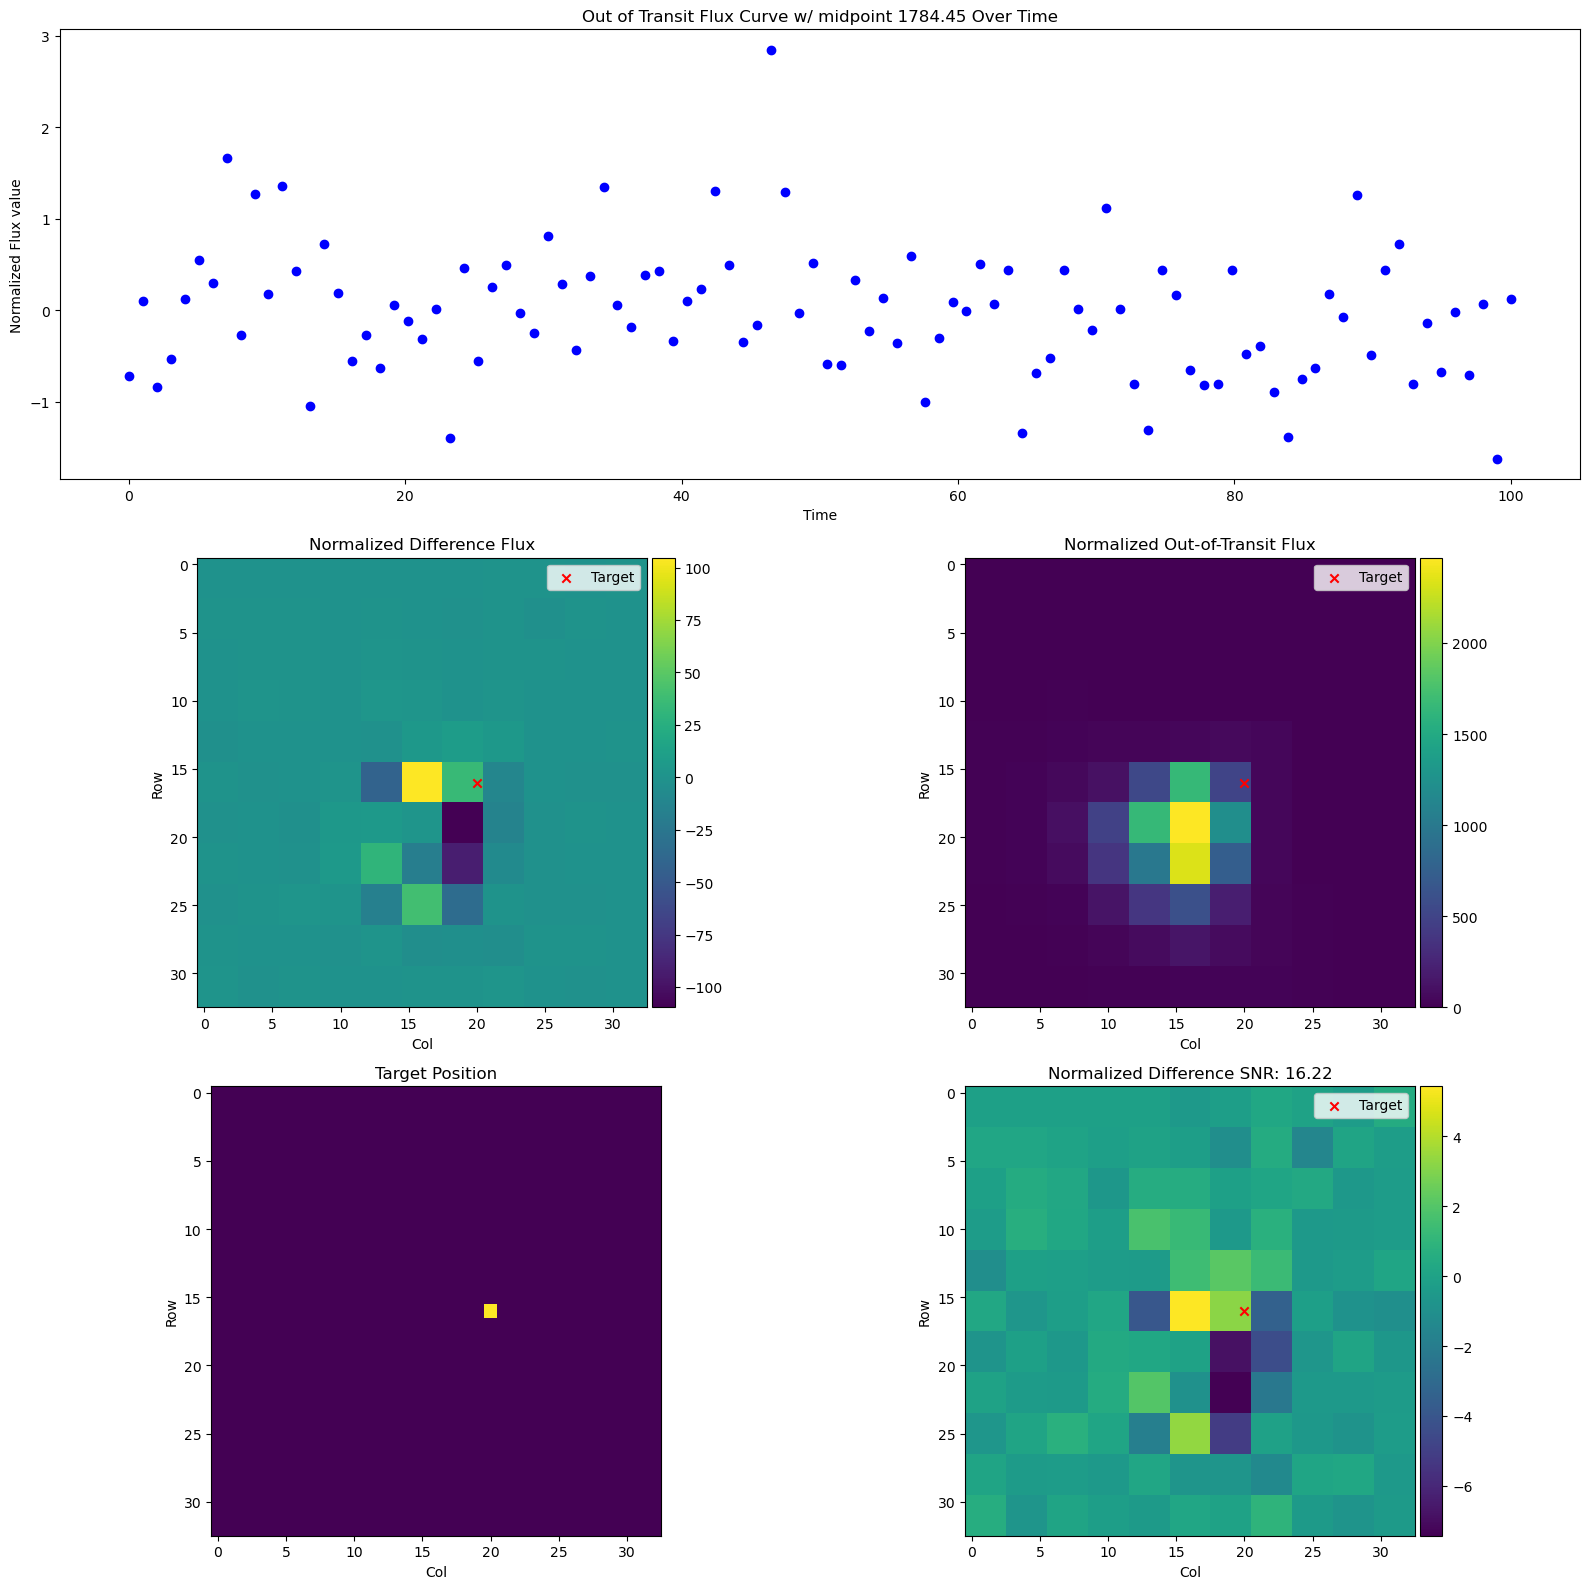

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

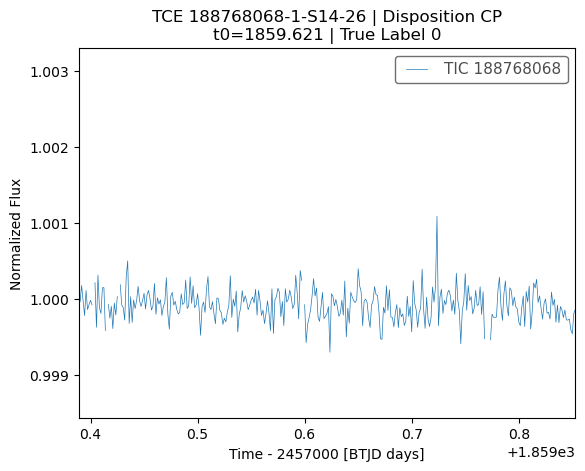

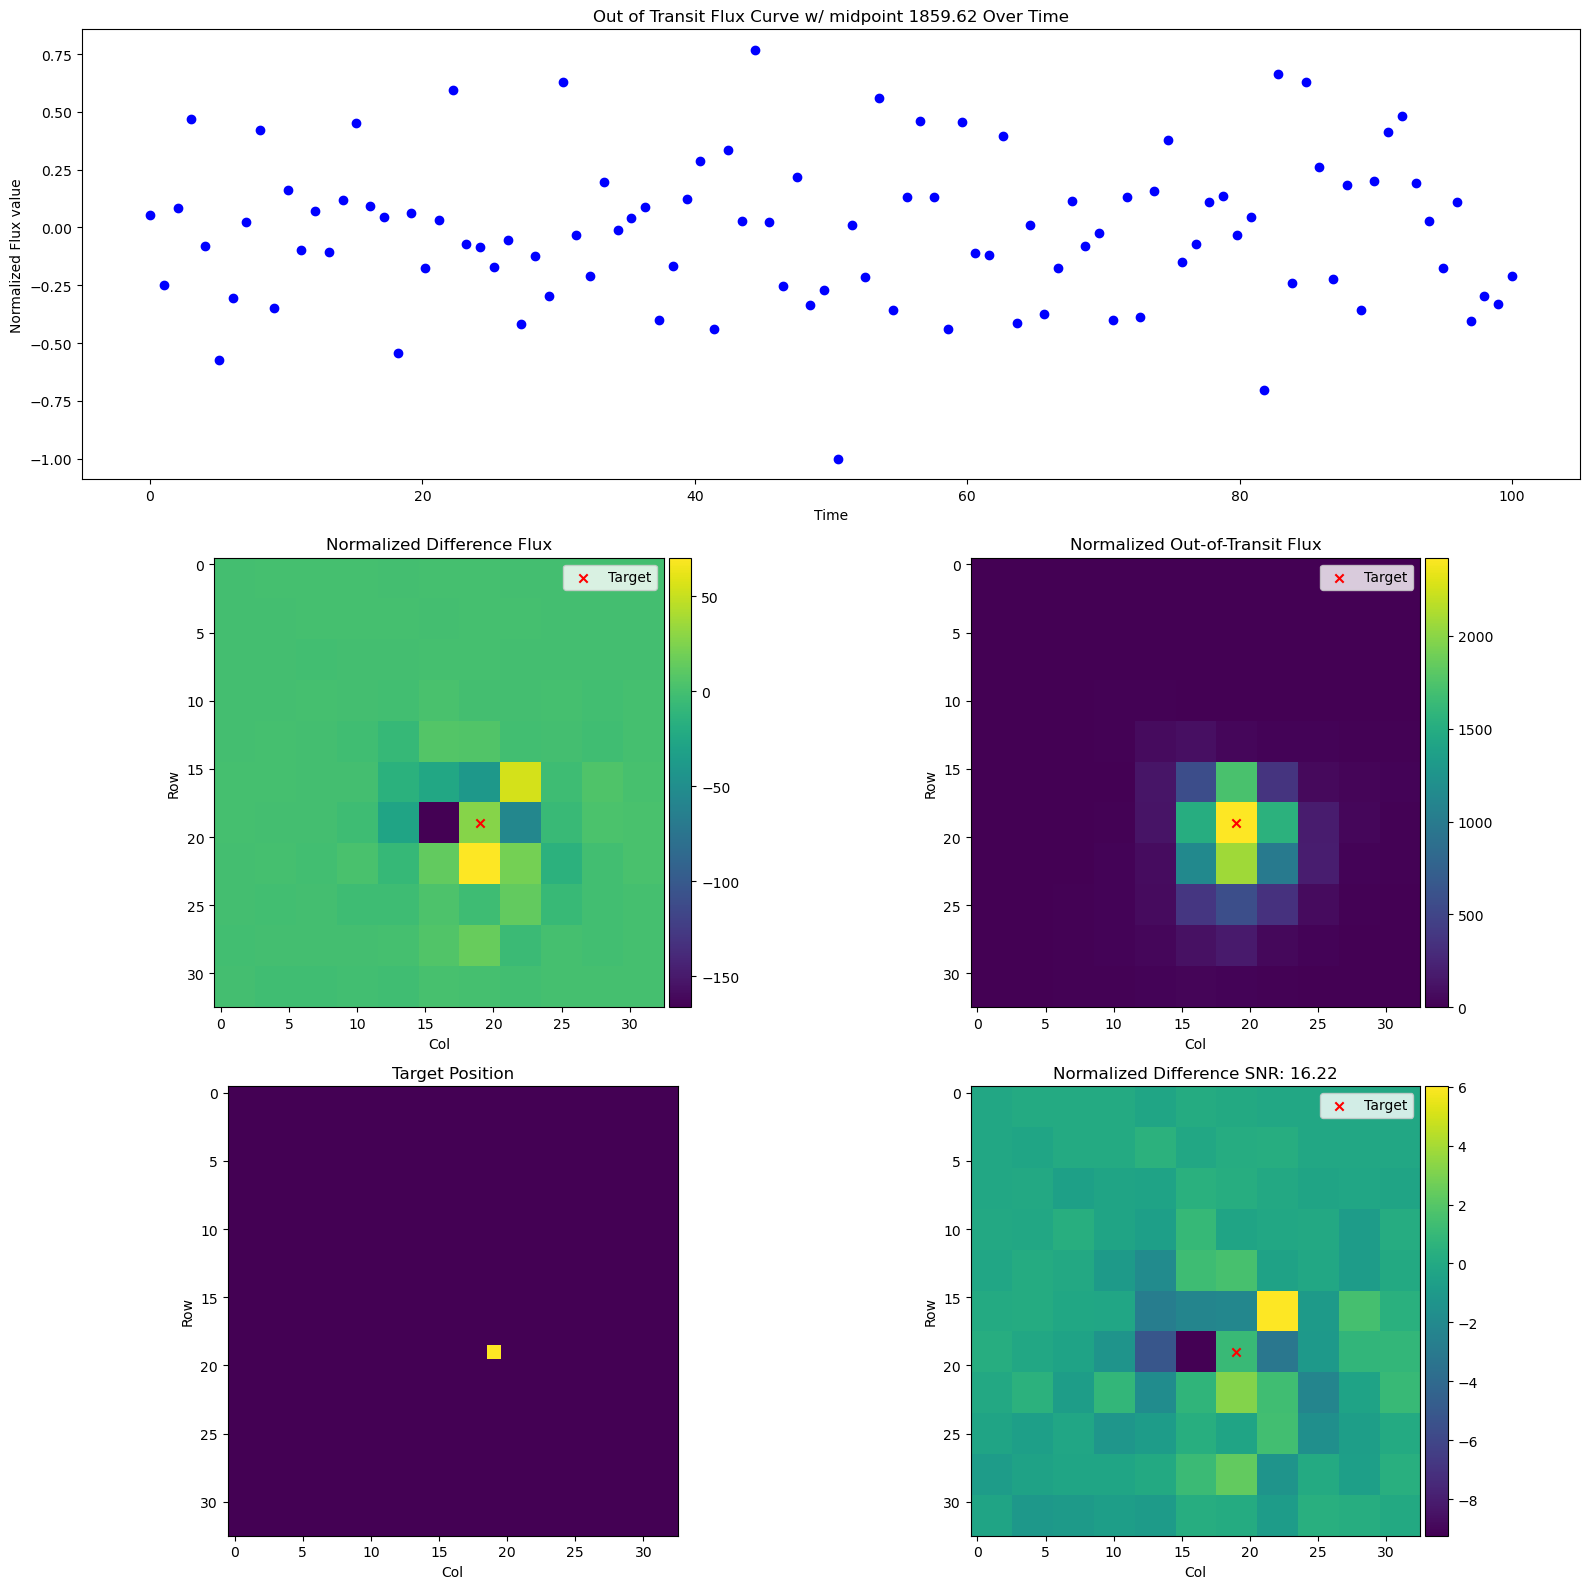

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

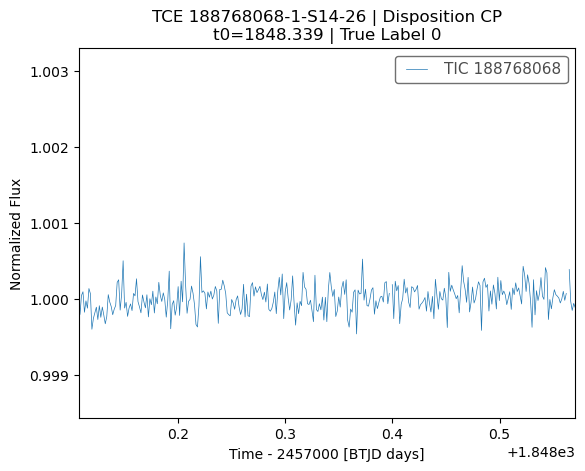

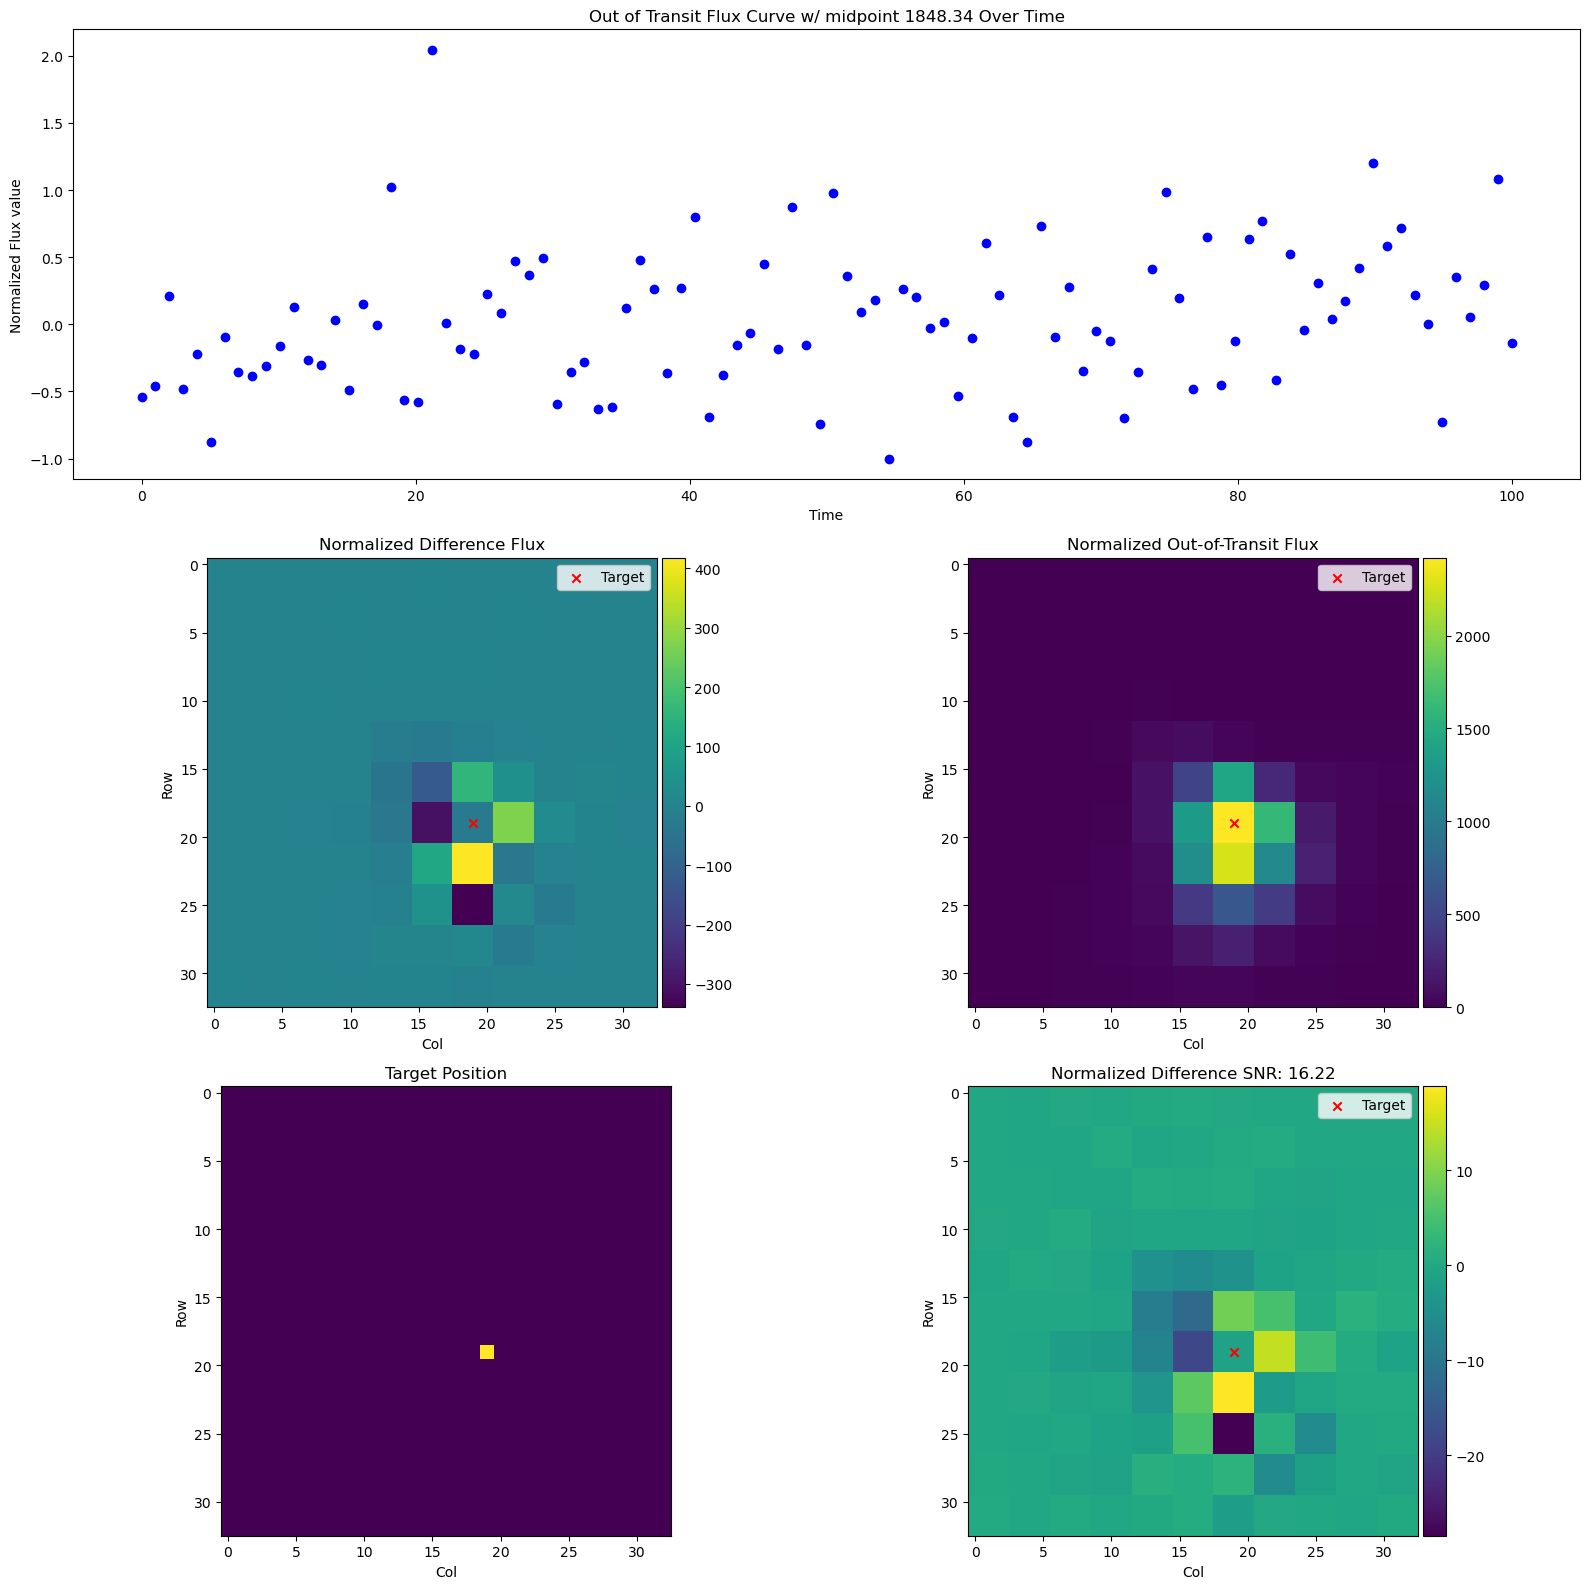

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

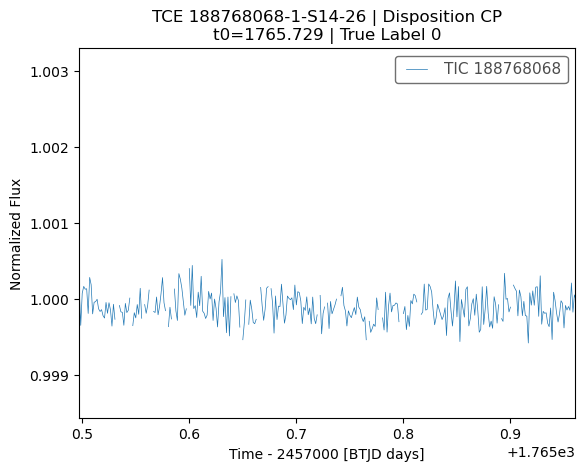

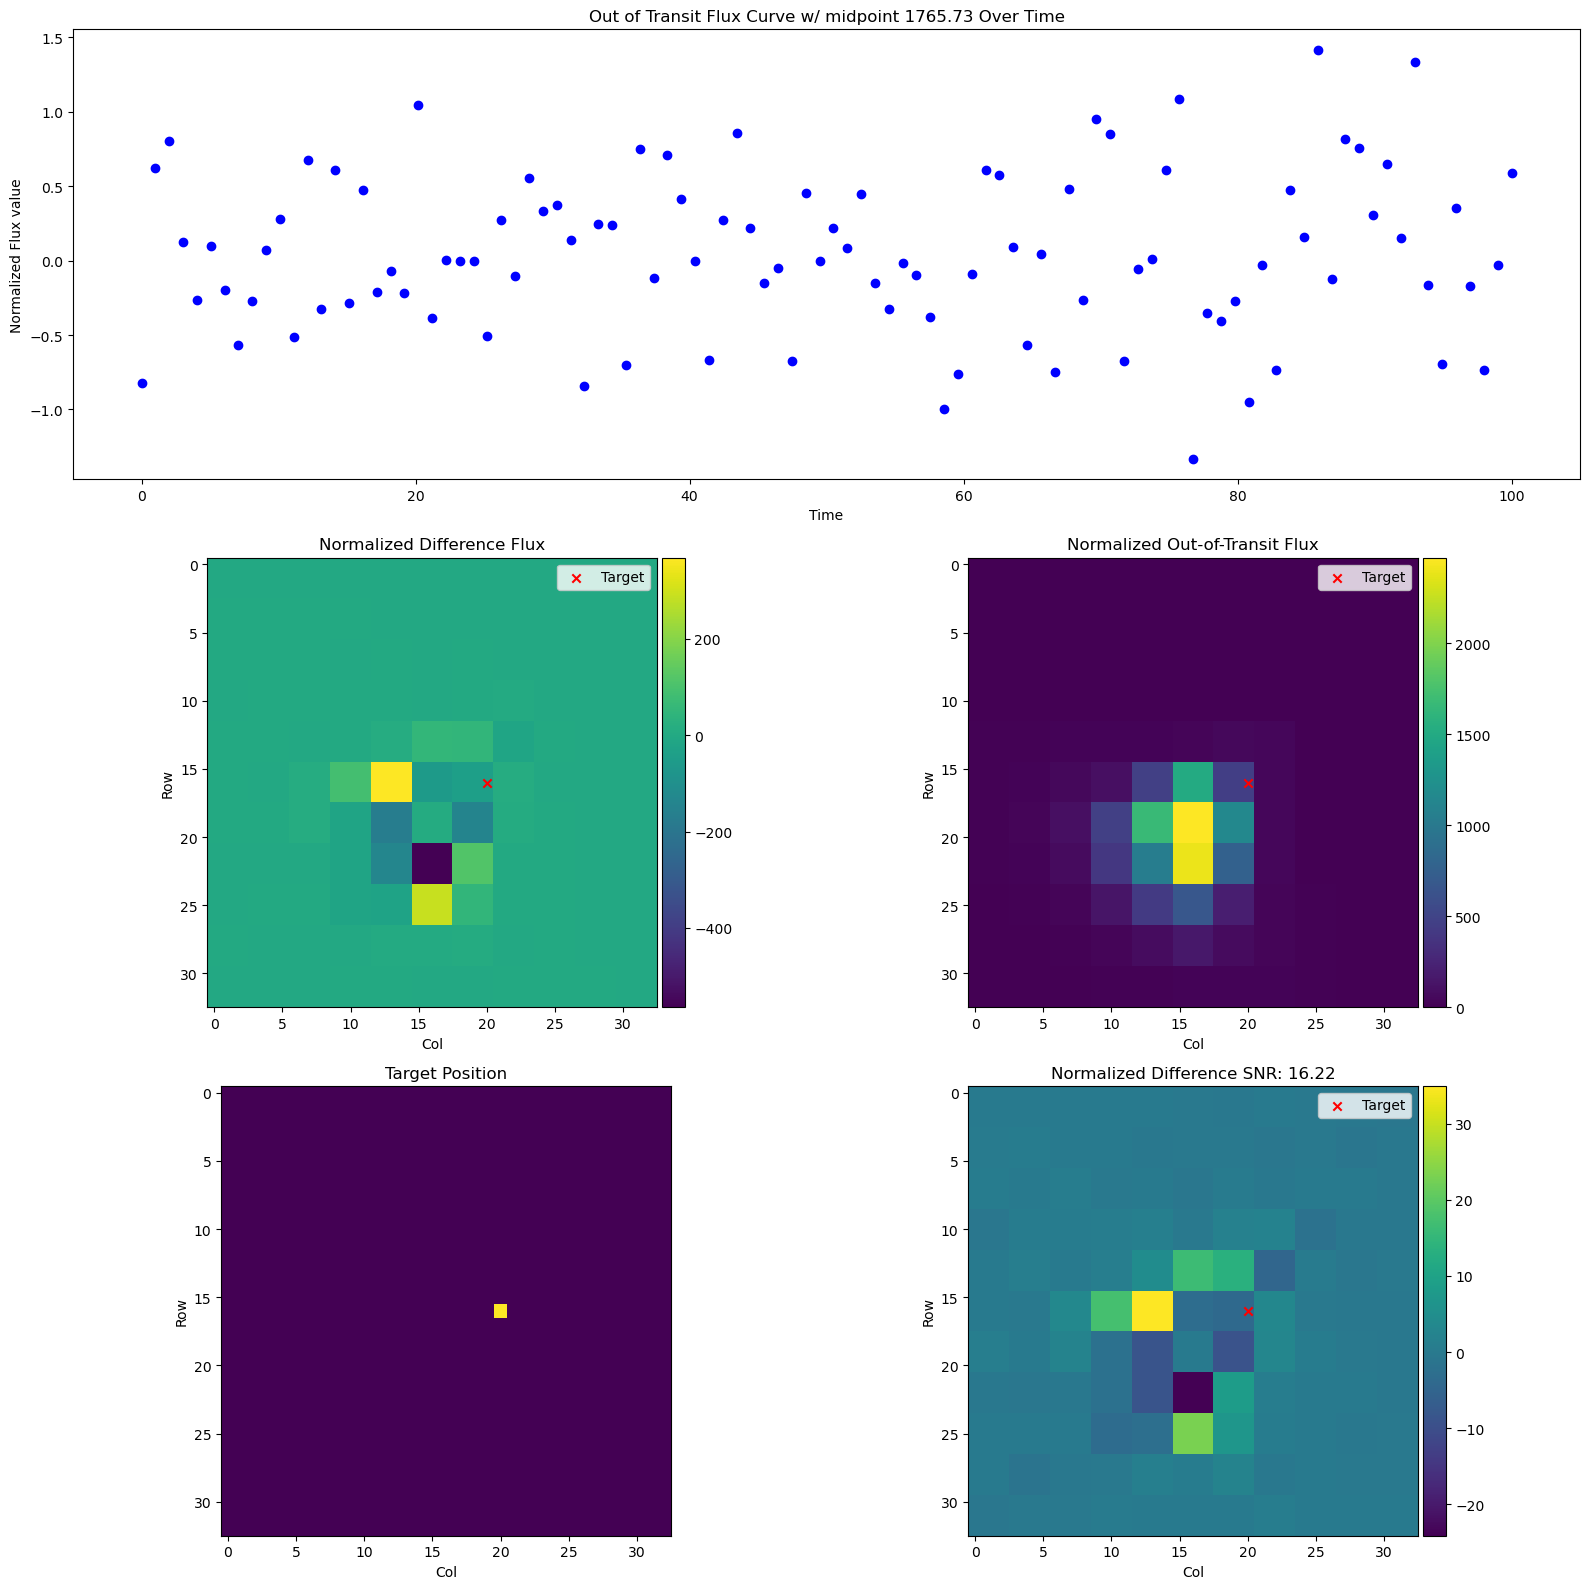

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

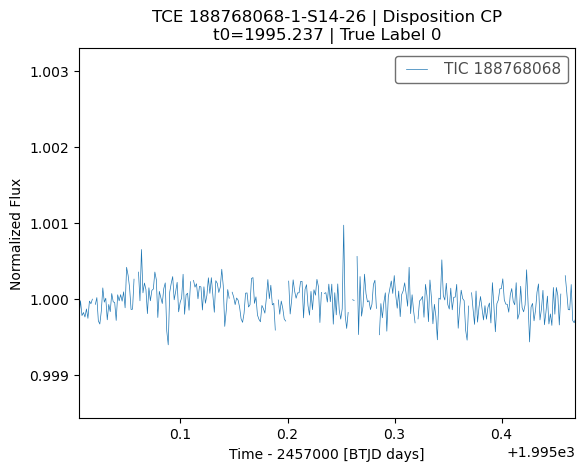

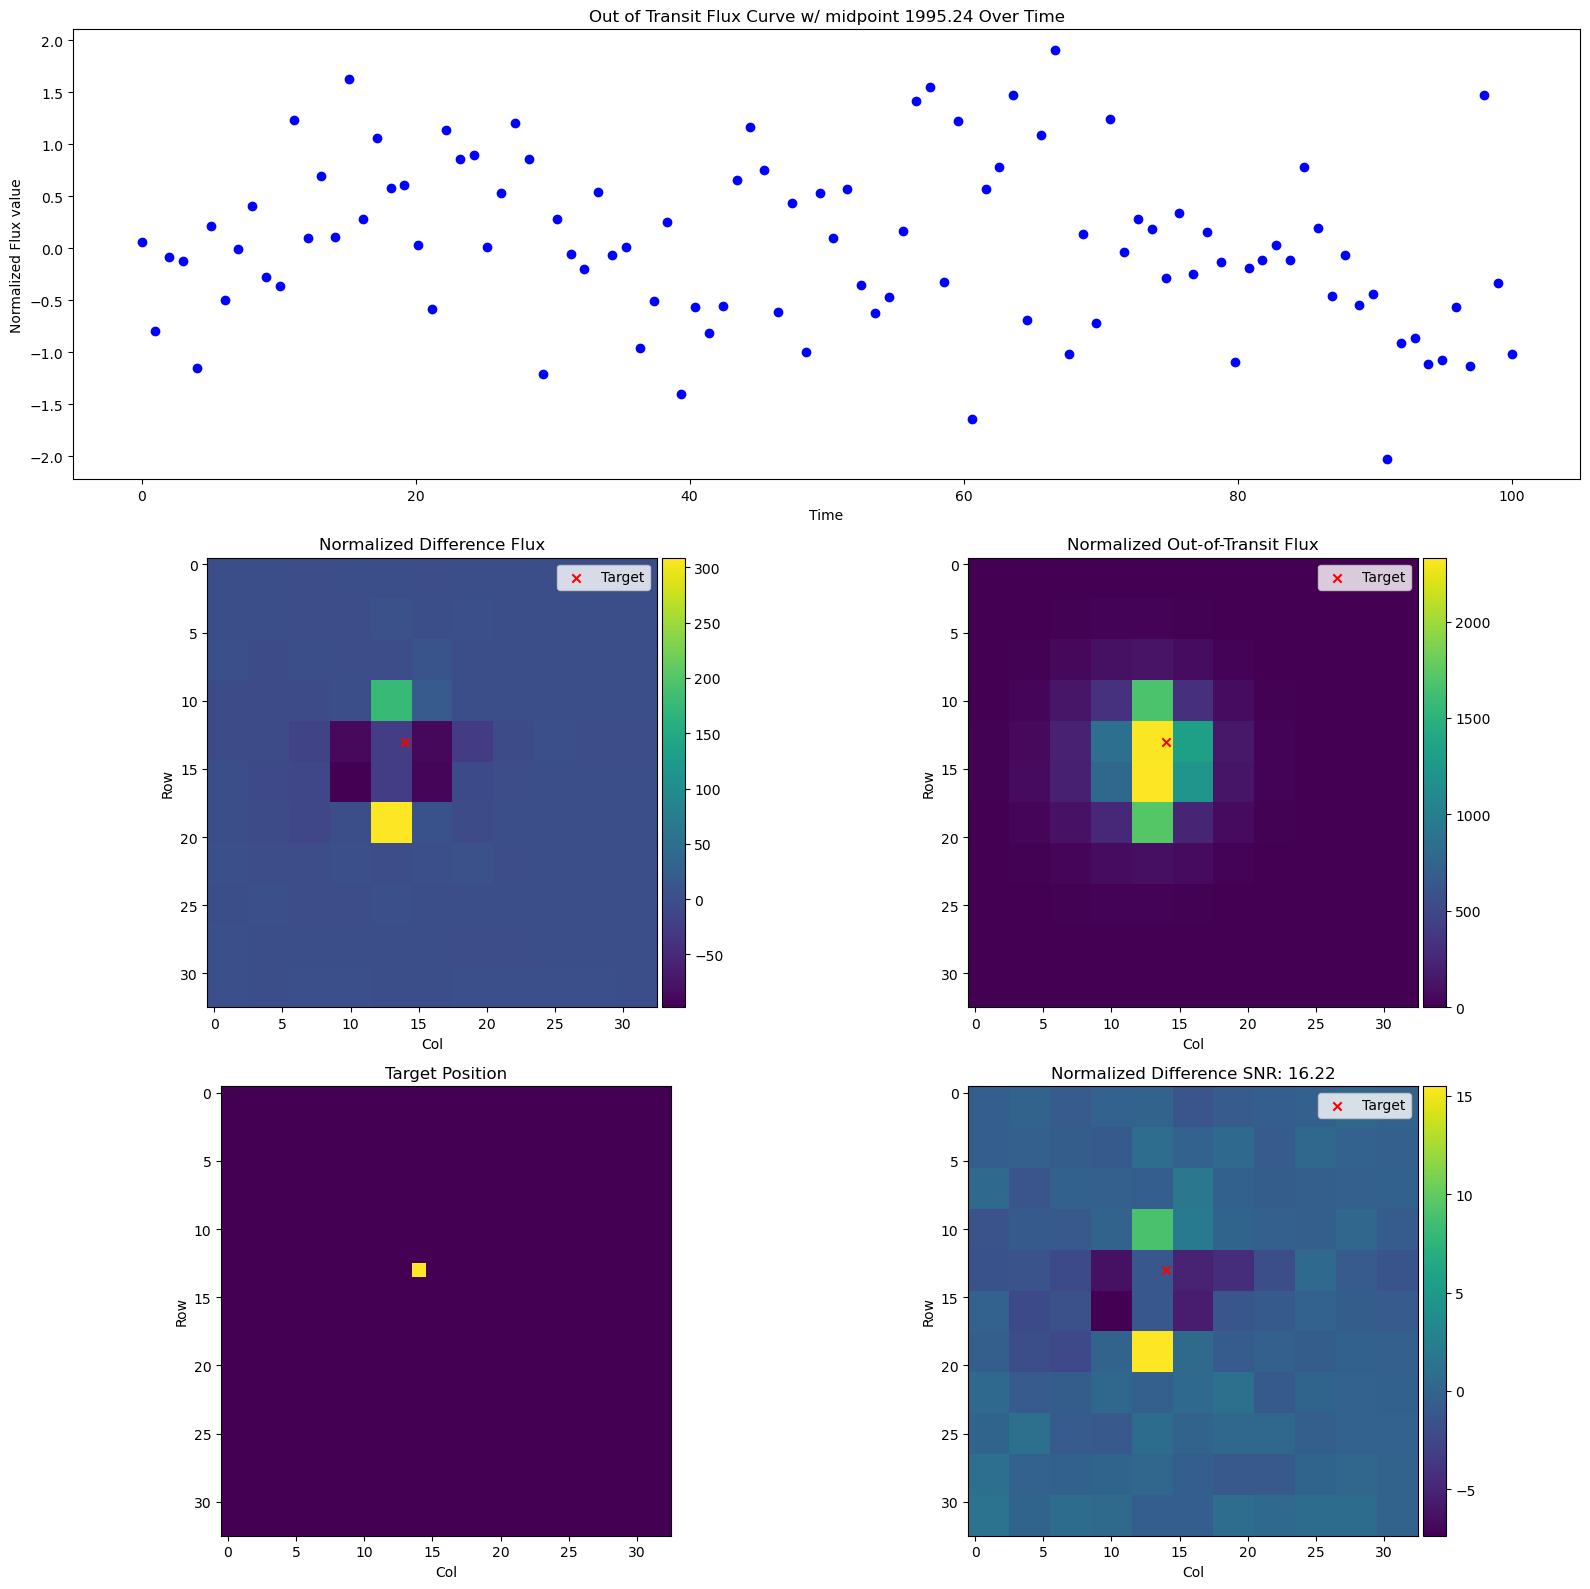

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

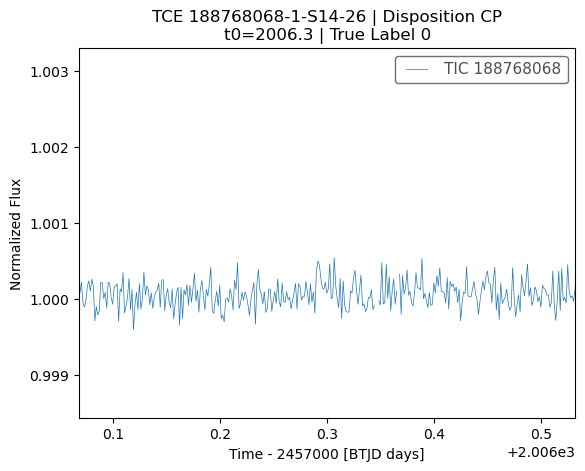

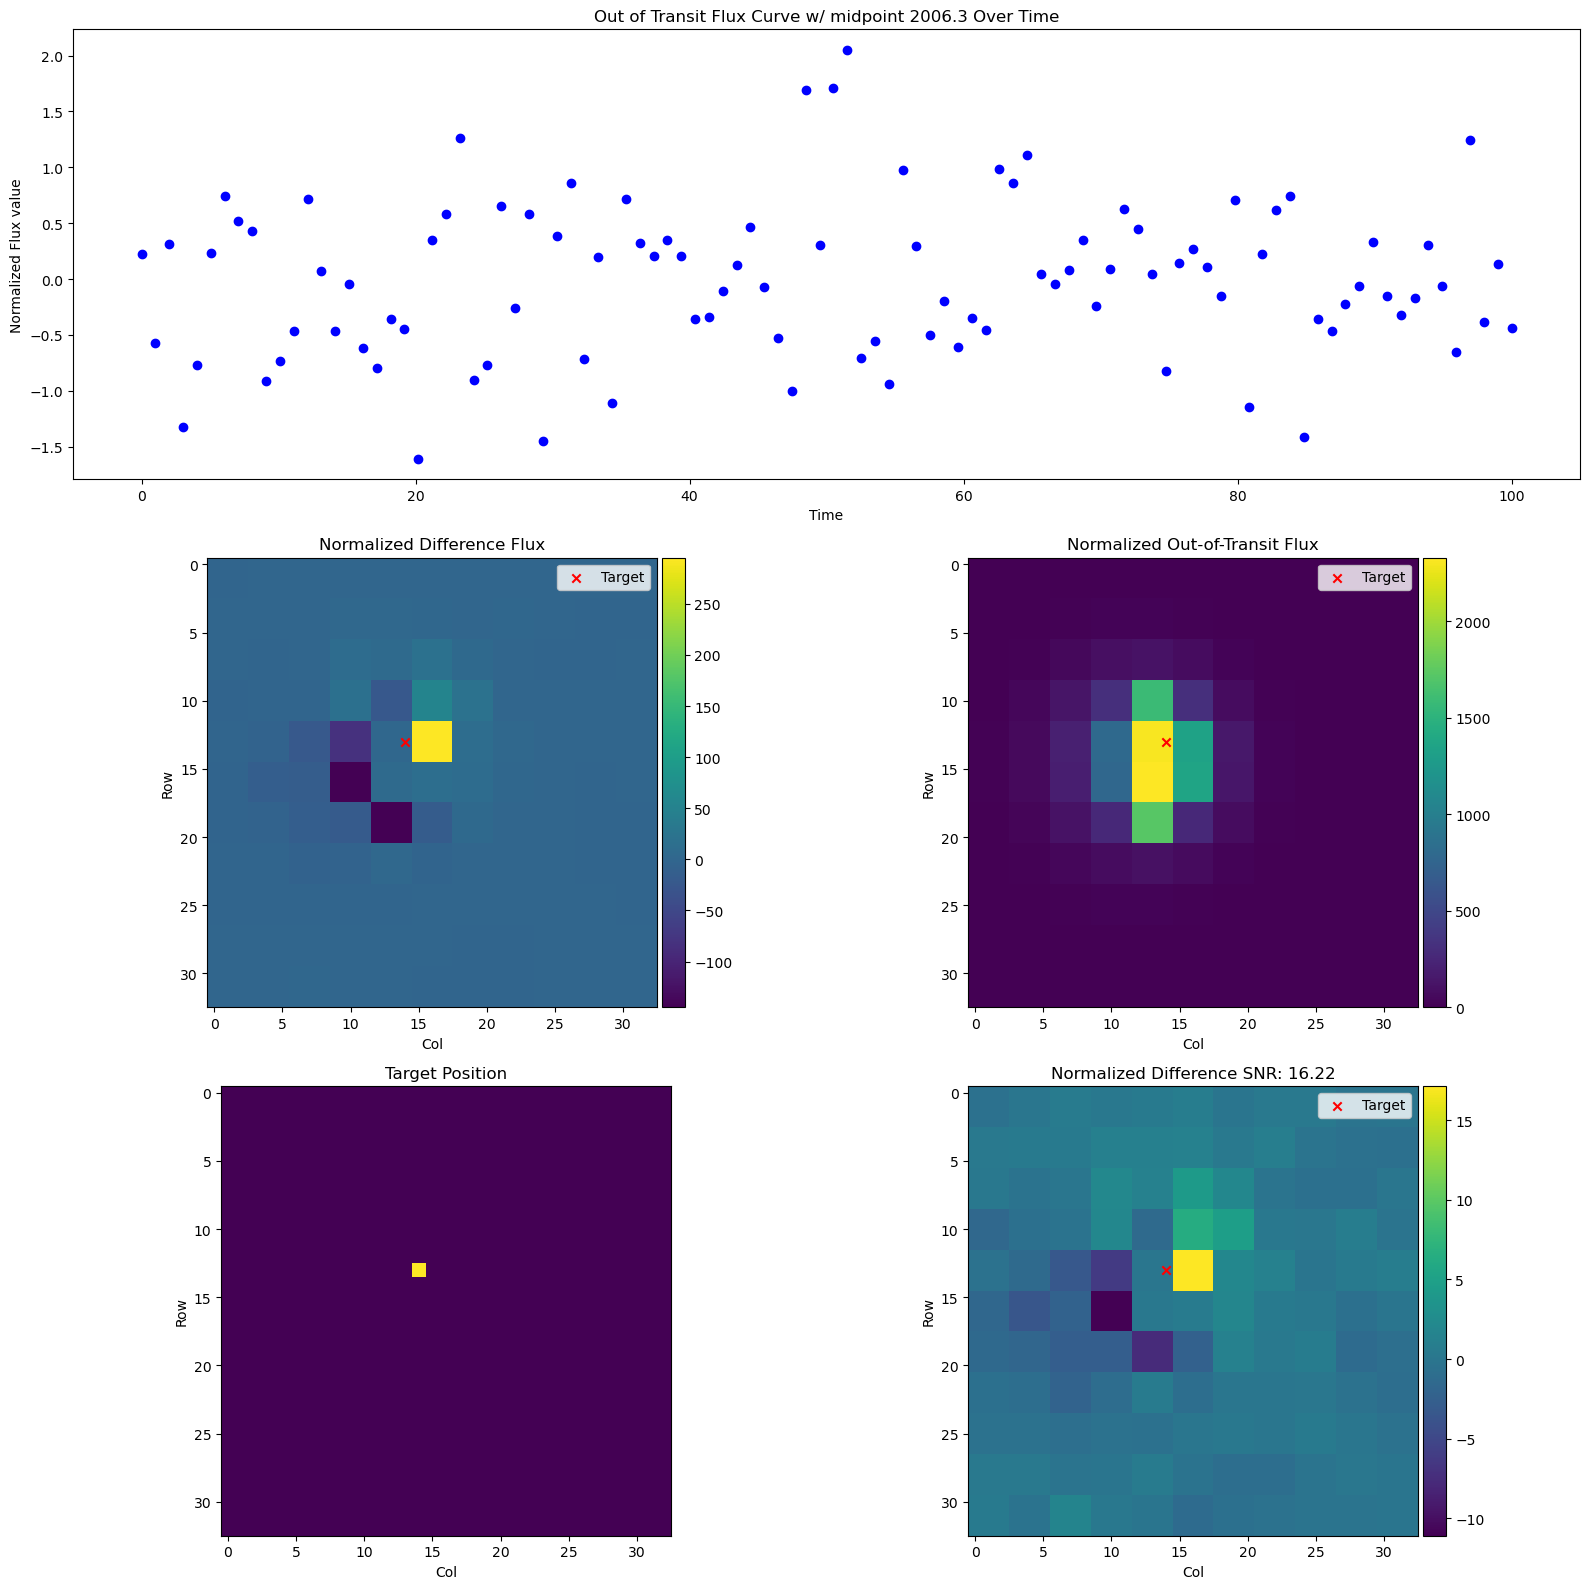

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

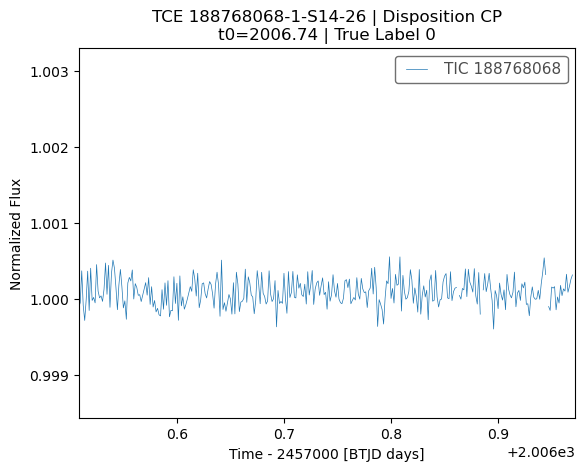

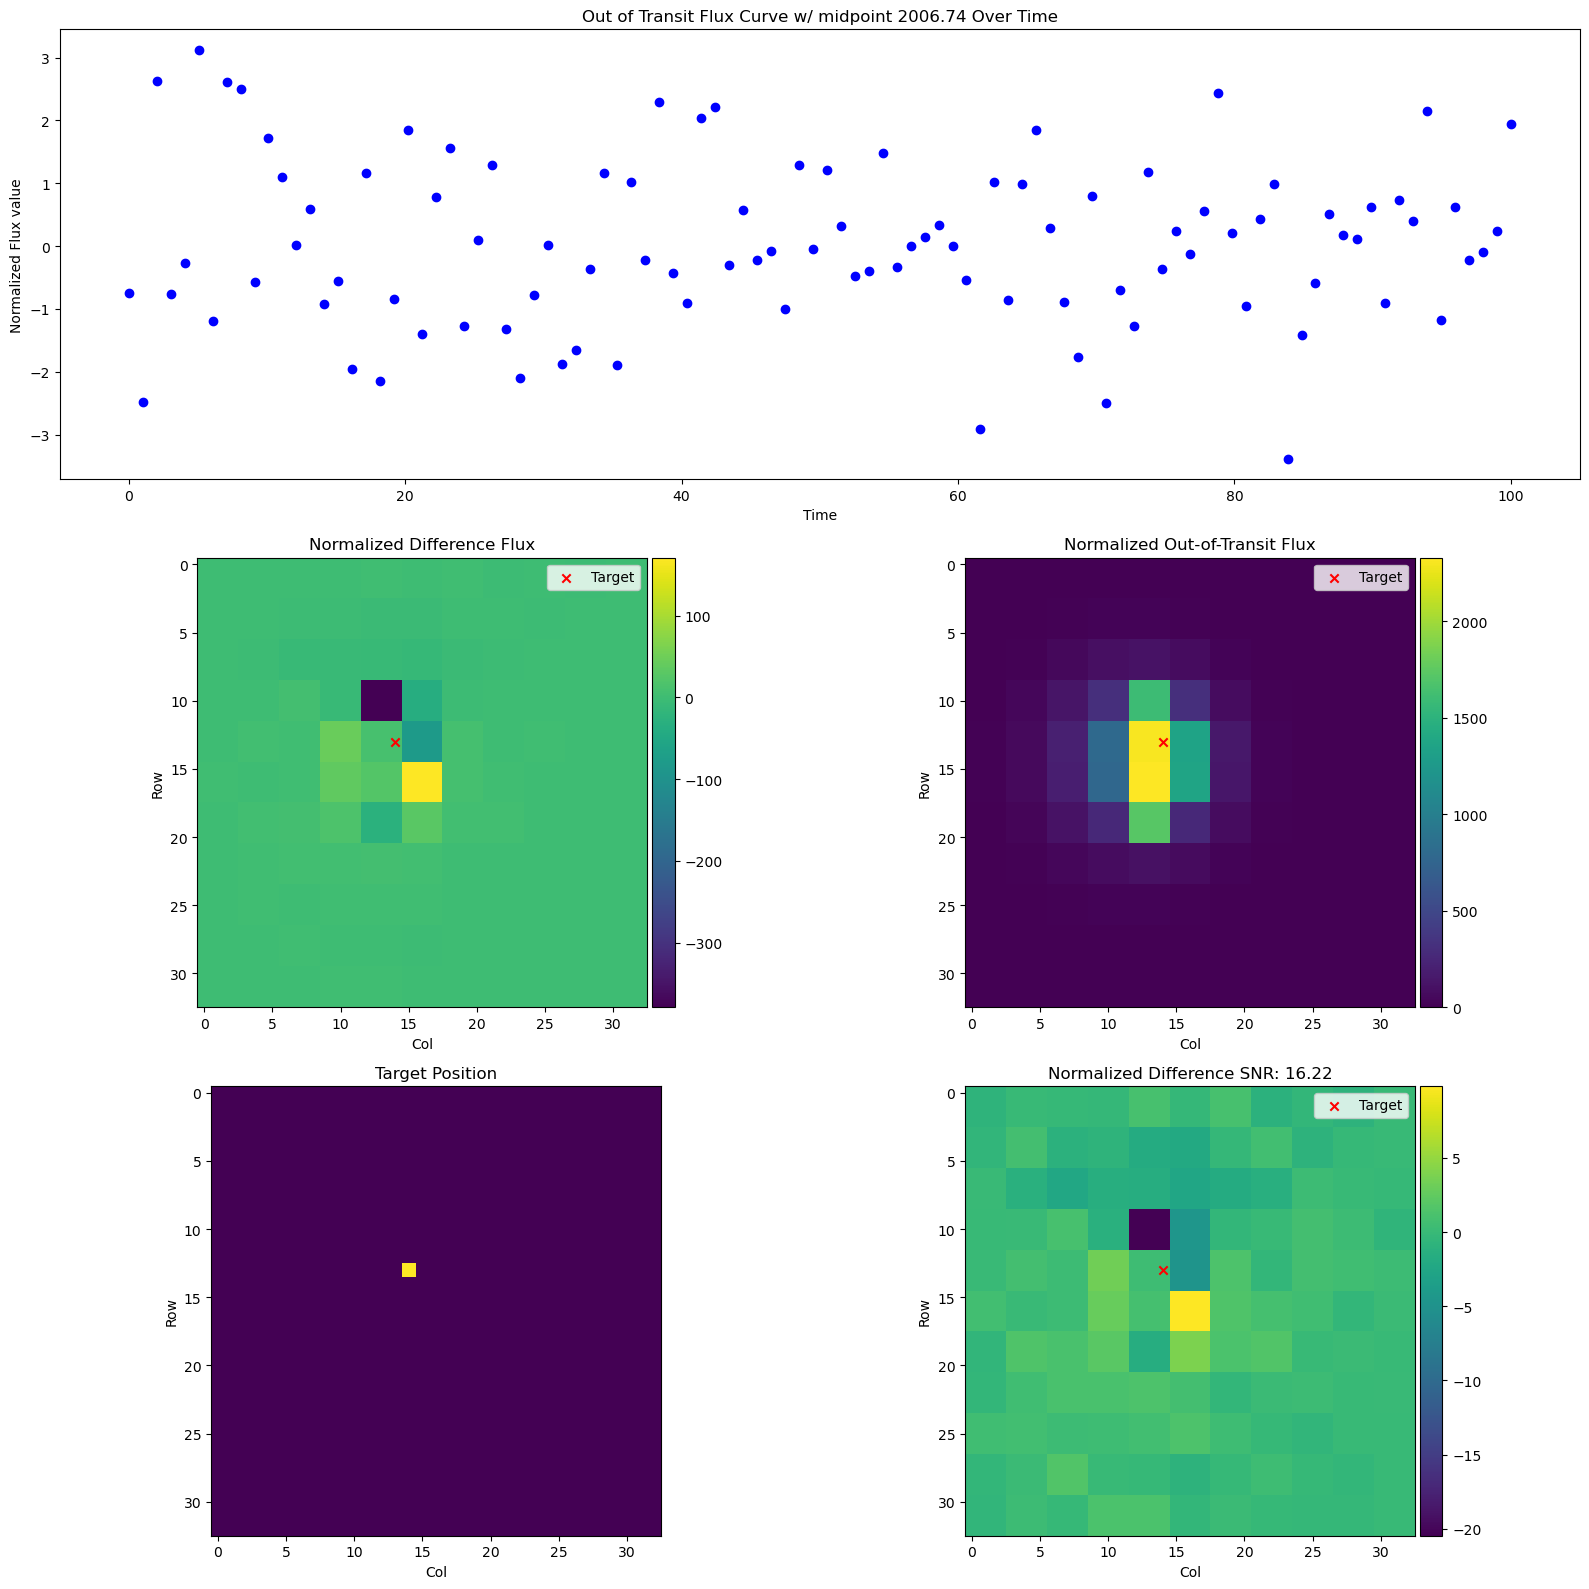

tic188768068
sector_arr: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
tried stitch
first lc t: 1764.6835866472495, last lc t: 2035.1355252359385
first_transit_time: 1766.0511853915411
first: 1766.0511853915411, last: 2036.1165331550108
midtransit_points_arr: [1766.05118539 1768.22913174 1770.4070781  1772.58502445 1774.7629708
 1776.94091716 1779.11886351 1781.29680986 1783.47475621 1785.65270257
 1787.83064892 1790.00859527 1792.18654163 1794.36448798 1796.54243433
 1798.72038069 1800.89832704 1803.07627339 1805.25421974 1807.4321661
 1809.61011245 1811.7880588  1813.96600516 1816.14395151 1818.32189786
 1820.49984421 1822.67779057 1824.85573692 1827.03368327 1829.21162963
 1831.38957598 1833.56752233 1835.74546869 1837.92341504 1840.10136139
 1842.27930774 1844.4572541  1846.63520045 1848.8131468  1850.99109316
 1853.16903951 1855.34698586 1857.52493221 1859.70287857 1861.88082492
 1864.05877127 1866.23671763 1868.41466398 1870.59261033 1872.77055669
 1874.94850304 1877.12644

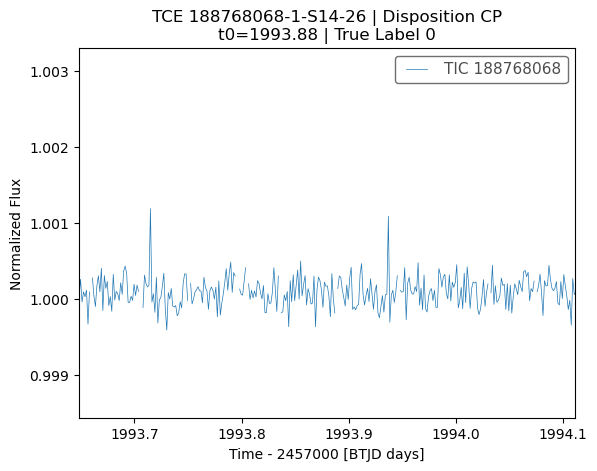

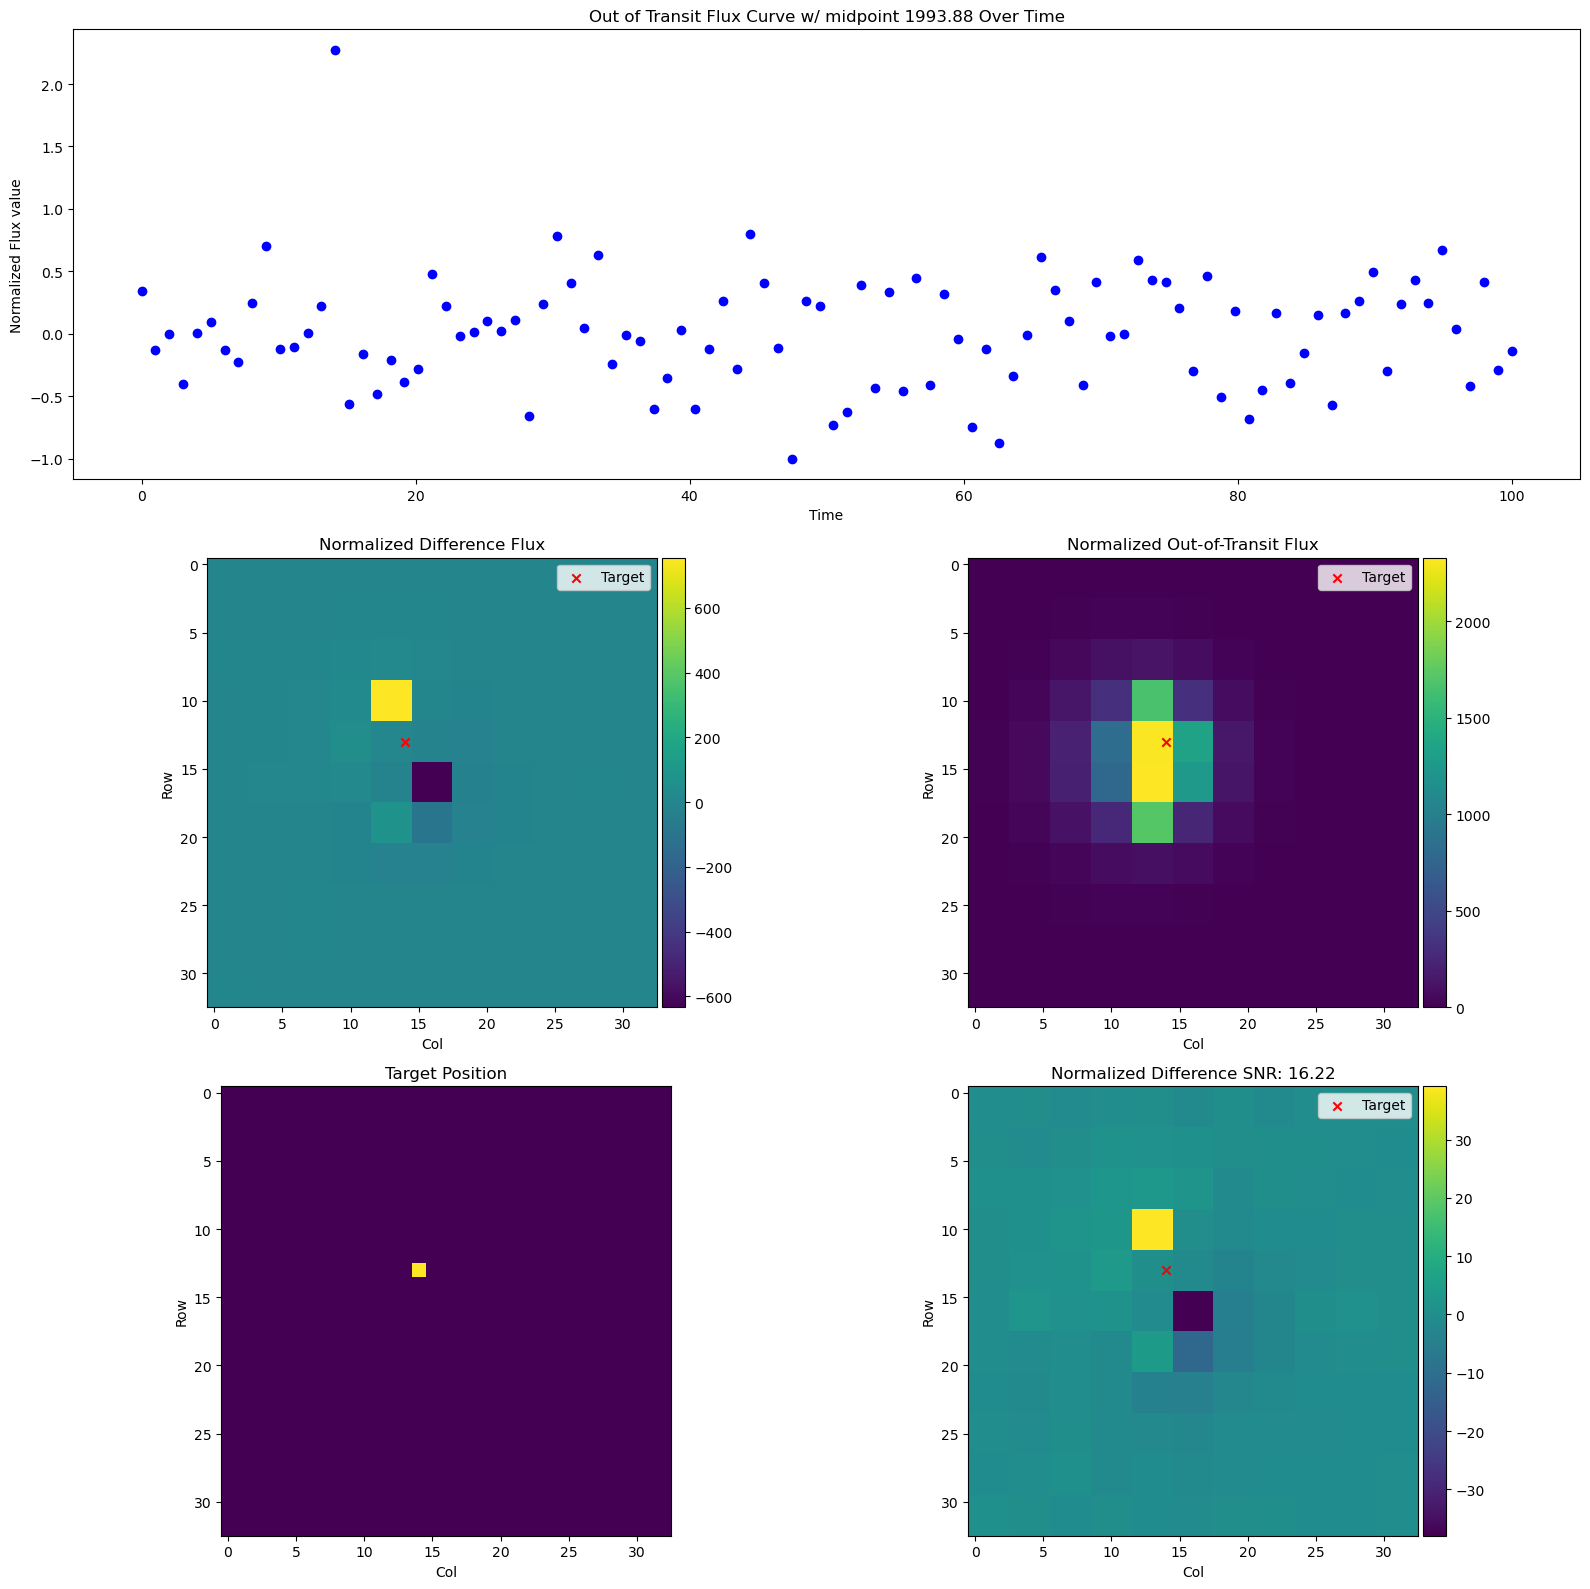

In [30]:
for i, row in sampled_tces.iterrows():
    uid = row["uid"]
    tce_uid = row["tce_uid"]
    true_label = row["label"]
    pred_label = row["bin_pred"]
    raw_pred_label = row["raw_pred"]
    confusion = row["confusion"]
    cf_pred_band = row["cf_pred_band"]
    cf_pred_band_label = row["cf_pred_band_label"]

    tce_time0bk = row["tce_time0bk"]
    tce_period = row["tce_period"]

    period_days = tce_period

    sector_run = [s for s in (tce_uid.split('S')[-1].split('-'))]

    sector_arr = []

    if len(sector_run) > 1:
        sector_arr = list(range(int(sector_run[0]), int(sector_run[1]) + 1))
    else:
        sector_arr = [int(sector_run[0])]

    tce = tce_tbl.loc[tce_tbl["tce_uid"] == tce_uid]

    # find light curve data for target
    print(f"tic{tce['target_id'].values[0]}")
    print(f"sector_arr: {sector_arr}")
    
    search_lc_res = lk.search_lightcurve(
        target=f"tic{tce['target_id'].values[0]}",
        mission="TESS",
        author=("TESS-SPOC", "SPOC"),
        exptime=120,
        cadence="long",
        sector=sector_arr,
    )

    lcf = search_lc_res.download_all(
        download_dir=str(lc_dir), quality_bitmask="default", flux_column="pdcsap_flux"
    )

    # def _lcf_masked_quantity_corrector(lcf: lk.LightCurve) -> lk.LightCurve:
    #     lcf = lk.LightCurve({"time": lcf.time.value, "flux": np.array(lcf.flux.value)})
    #     return lcf.normalize()

    try:
        print("tried stitch")
        lcf_stitched = lcf.stitch()
    except Exception as e:
        print(f"error: {e}")
        # lcf_stitched = lcf.stitch(corrector_func=_lcf_masked_quantity_corrector)
    
    time = lcf_stitched.time.value

    first_transit_time = _find_first_epoch_after_this_time(
        tce_time0bk, period_days, time[0]
    )

    midtransit_points_arr = np.array(
        [
            first_transit_time + phase_k * period_days
            for phase_k in range(int(np.ceil((time[-1] - time[0]) / period_days)))
        ]
    )

    print(f"first lc t: {time[0]}, last lc t: {time[-1]}")
    print(f"first_transit_time: {first_transit_time}")
    print(f"first: {midtransit_points_arr[0]}, last: {midtransit_points_arr[-1]}")
    print(f"midtransit_points_arr: {midtransit_points_arr}")
    

    print(f"\n Example {i + 1}")
    print(f"UID: {uid}")
    print(f"Confusion: {confusion}")
    print(f"Raw pred: {raw_pred_label:.3f}, Confusion Band: {cf_pred_band_label}")
    print(f"True label: {true_label}, Pred label: {pred_label}, ")

    # _plot_tce_t_vs_oot_example_scatter
    # _plot_tce_t_vs_oot_hist
    
    ex_plot_dir = tce_plot_dir / confusion / cf_pred_band_label
    ex_plot_dir.mkdir(parents=True, exist_ok=True)
    
    _plot_tce_ex_pdcsap_lc_from_lk(uid, true_label, ex_plot_dir)
    _plot_tce_ex_lc_diff_imgs_from_tfrec(uid, ex_plot_dir)
